# Кредитный скоринг

# Оглавление


<a href='#1' > <B> 1. Постановка задачи и выяснение общей картины </B>
    
    
<a href='#1.1'> 1.1 Как будет использоваться наше решение
    
<a href='#1.2'> 1.2 Как выглядят текущие решения?
    
<a href='#1.3'> 1.3 Как нужно сформулировать задачу?

<a href='#1.4'> 1.4 Как измерять эффективность
    
<a href='#1.5'> <B>Подключение библиотек </B> 
    
<a href='#1.6'> <B>Пользовательсике функции</B>
    
<a href='#1.7'> <B>Пользовательские классы</B>
    
<a href='#2'> <B>2. Получение данных</B>
    
<a href='#2.1'> 2.1 Создаем главный сет
    
<a href='#2.2'> 2.2 Описание признаков
    
<a href='#2.3'> 2.3 Размер и тип данных
    
<a href='#3'> <B>3. EDA</B>

<a href='#3.1'> 3.1 Осмотр числовых признаков, с помощью гистограмм    

<a href='#3.2'> 3.2 Осмотр числовых признаков с помощью бокс-плотов
    
<a href='#3.3'> 3.3 Корреляция числовых признаков
    
<a href='#3.4'> 3.4 Осмотр категориальных признаков
    
<a href='#3.5'> 3.5 Анализ бинарных признаков
    
<a href='#3.6'> 3.6 Осмотр признака даты
    
<a href='#4'> <B>4 Создание новых признаков (Feature Engineering)</B>
    
<a href='#4.1'> 4.1 Матрица корреляций для категориальных признаков
    
<a href='#4.2'> 4.2 Оценка важности категориальных переменных
    
<a href='#4.3'> 4.3 Оценка важности численных переменных    
    
<a href='#4.4'> 4.4 Стандартизация и фиктивное кодирование
    
<a href='#4.5'> 4.5 Масштабирование №2. Нормализация и стандартизация    
    
<a href='#5'> <B>5 Выбор модели ML</B>
    
<a href='#5.1'> 5.1 Простая модель
    
<a href='#5.2'> 5.2 Модель 2

<a href='#5.3'> 5.3 Модель 3

<a href='#5.4'> 5.4 Поиск оптимальных параметров для моделей лог.регресии
    
<a href='#5.5'> 5.5  Модель 5
    
<a href='#6'> <B>6 Балансировка классов</B>
    
<a href='#6.1'> 6.1 Применение Undersampling
    
<a href='#6.2'> 6.2 Применение Oversampling
    
<a href='#6.3'> 6.3 Undersampling и Oversampling с использованием imbalanced-learn    
    

<a id='1'></a>
# 1. Постановка задачи и выяснение общей картины


Есть датасет с информацией по банковским клиентам. Нужно на его основе создать классификатор, который распозновал бы ненадежных клиентов.



<a id='1.1'> </a>
### 1.1 Как будет использоваться наше решение

На выходе необходимо получить вероятность, с которой клиент относится к той или иной категории. Далее вопрос решается менеджером банка.

<a id='1.2'> </a>
### 1.2 Как выглядят текущие решения?

В: На что похоже решение сейчас? Как сейчас решают давать кредит или нет?

О: Сейчас решение о выдачи кредита принимает менеджер банка на основе накопленного опыта. 

Это накладно и не всегда верно.

<a id='1.3'> </a>
### 1.3 Как нужно сформулировать задачу?

Это задача:
- обучение с учиетелем
- классификация
- в данном случае пакетное обучение - потому, что нет потока данных и их мало.


<a id='1.4'> </a>
### 1.4 Как измерять эффективность 

В данном случае мы ищем наилучшее значение ROC - AUC. Хотя для несбалансированных классов лучше смотреть на соотношение "точность/полнота". Более того, для оценки именно бизнесс задачи лучше использовать значение f1 меры. Желательно найти баланс между этими оценками. 

<a id='1.5'> </a>
# Подключение библиотек

In [88]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

# Common imports
import numpy as np
import pandas as pd
import os
import seaborn as sns


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [89]:
# Установка random_seed
RS = 42

<a id='1.6'> </a>
# Пользовательсике функции

In [90]:
def log_and_print(DataFrame):
    
    '''
    Функция для отрисовки логарифмированных признаков, для проверки
    какому признаку подойдет логарифмирование
    '''
    
    num_attr = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
    n = len(num_attr) # количество рисунков 
    i = 1 # номер рисунка
    plt.figure(figsize=(8,24))
    for col in num_attr:
        new_col = col+'_log'
        DataFrame[new_col] = DataFrame[col].apply(lambda x: np.log(x + 1))
        plt.subplot(n,1,i)
        DataFrame[new_col].hist()
        plt.xlabel(new_col, fontsize=12, color='blue')
        plt.ylabel('Количество', fontsize=12, color='blue')
        plt.title('Лог-распределение атрибута "{}"'.format(col), fontsize=14, color='green')
        plt.grid(which='major', linewidth=1.2) # Главная 
        plt.grid(which='minor', linestyle='--', color='gray', linewidth=0.5) # Вспомогательная
        plt.minorticks_on() # Включить показ минорной сетки
        i+=1
        
def box_plot_print(DataFrame):
    
    '''
    Функция для отрисовки боксплотов для числовых признаков
    '''
    
    num_attr = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
    n = len(num_attr) # количество рисунков 
    i = 1 # номер рисунка
    plt.figure(figsize=(8,25))
    for col in num_attr:
        plt.subplot(n,1,i)
        sns.boxplot(x='default', y=col, data=DataFrame)
        plt.xlabel('default', fontsize=12, color='blue')
        
        plt.title('Бокс-плот для атрибута "{}"'.format(col), fontsize=14, color='green')
        plt.grid(which='major', linewidth=1.2) # Главная 
        plt.grid(which='minor', linestyle='--', color='gray', linewidth=0.5) # Вспомогательная
        plt.minorticks_on() # Включить показ минорной сетки
        i+=1
        
        
def print_cat_attr(DataFrame):
    '''
    Функция для осмотра категориальных признаков
    
    '''
    
    n = len(cat_attr) # количество рисунков 
    i = 1 # номер рисунка
    plt.figure(figsize=(15,33))
    for col in cat_attr:
        plt.subplot(n,1,i)
        sns.countplot(data=DataFrame, hue='default', x=col)
        plt.xlabel('Количество', fontsize=12, color='blue')
        plt.ylabel(col, fontsize=12, color='blue')
        plt.title('Распределение атрибута "{}"'.format(col), fontsize=14, color='green')
        plt.grid(which='major', linewidth=1.2) # Главная 
        plt.grid(which='minor', linestyle='--', color='gray', linewidth=0.5) # Вспомогательная
        plt.minorticks_on() # Включить показ минорной сетки
        i+=1
        
        
def print_def_per_edu(DateFrame):
    '''
    График образование - доход
    '''
    dd = DateFrame['education'].value_counts().to_dict()
    mean_age = DateFrame.groupby(by = 'education')['income'].agg('mean').reset_index()
    mean_age['cnt'] = mean_age['education'].apply(lambda x: dd[x])
    mean_age = mean_age.sort_values(by=['cnt'], ascending=False)
    fig = plt.figure()
    axes = fig.add_axes([0, 0, 2, 1])
    sns.countplot(data=DateFrame, hue='default', x='education', ax=axes)
    axes2 = axes.twinx()
    axes2.plot(mean_age['education'], mean_age['income'], color = 'red', label='Средняя прибыль')
    axes2.grid(axis = 'y')
    axes.set_ylabel('Количесвто клиентов')
    axes.set_xlabel('Уровень образования')
    axes2.set_ylabel('Средний доход');
    
def print_bin_attr(DataFrame):
    
    '''
    Функция для анализа бинарных признаков
    '''
    
    n = len(bin_attr) # количество рисунков 
    i = 1 # номер рисунка
    plt.figure(figsize=(15,33))
    for col in bin_attr:
        plt.subplot(n,1,i)
        sns.countplot(data=DataFrame, hue='default', x=col)
        plt.xlabel(col, fontsize=12, color='blue')
        plt.ylabel('Количество', fontsize=12, color='blue')
        plt.title('Распределение атрибута "{}"'.format(col), fontsize=14, color='green')
        plt.grid(which='major', linewidth=1.2) # Главная 
        plt.grid(which='minor', linestyle='--', color='gray', linewidth=0.5) # Вспомогательная
        plt.minorticks_on() # Включить показ минорной сетки
        i+=1
    
def print_def_per_income(DateFrame):
    '''
    Функция для рисования графика "доход-месяц"
    '''
    def def_per_month(d):
        dop_1 = DateFrame['new_date'].value_counts().sort_index()
        for i in range(1,5):
            new_d = round((d/dop_1[i])*100,2)
            return new_d
    dop_2 = DateFrame.groupby(by = 'new_date')['default'].agg('sum').reset_index()
    dop_2['def_per'] = dop_2['default'].apply(def_per_month)
    
    mean_in = DateFrame.groupby(by = 'new_date')['income'].agg('mean').reset_index()
    mean_in['new_date'] = mean_in['new_date'].apply(lambda x: {1:'Январь', 2:'Февраль', 3:'Март', 4:'Апрель'}[x])
    mean_in
    
    fig = plt.figure()
    axes = fig.add_axes([0, 0, 2, 1])
    sns.countplot(data=DateFrame, hue='default', x='new_date', ax=axes)
    a = 0.13
    for i in range(4):

        plt.text(a, 2800., '{}%'.format(dop_2['def_per'].loc[i]), fontsize=15)
        a += 1
    

    axes2 = axes.twinx()

    axes2.plot(mean_in['new_date'], mean_in['income'], color = 'red', label='Средняя прибыль')
    axes2.grid(axis = 'y')
    axes.set_ylabel('Количесвто клиентов')
    axes.set_xlabel('Месяцы')
    axes2.set_ylabel('Средний доход в месяц');
    
def income_cat_proportions(data):
    '''
    Функция для сравнения ошибок в равномерном разделении
    '''
    return data["default"].value_counts() / len(data)

    
def model_compare(model_name, alg_type, balance, Y_TEST, Y_PRED, Y_PRED_PROB, new=True ):
    '''
    Функция создает датасет для сравнения метрик моделей
    '''
    
    if new:
        list_1 = []
        list_2 = []
        list_3 = []
        list_4 = []
        list_5 = []
        list_6 = []
        list_7 = []
    list_1.append(model_name)
    list_2.append(alg_type)
    list_3.append(balance)
    list_4.append(round(precision_score(Y_TEST, Y_PRED), 3))
    list_5.append(round(recall_score(Y_TEST, Y_PRED), 3))
    list_6.append(round(f1_score(Y_TEST, Y_PRED), 3))
    list_7.append(round(roc_auc_score(Y_TEST, Y_PRED_PROB[:,1]), 6))

    Model_set = pd.DataFrame({
        'Модель': list_1,
        'Алгоритм' : list_2,
        'Баланс' : list_3,
        'Точность' : list_4,
        'Полнота' : list_5,
        'F1 мера' : list_6,
        'ROC AUC' : list_7
    }).sort_index()
    
    return Model_set
    

def print_CM(Y_TEST, Y_PRED):
    ''' 
    Функция для визуализации матрицы ошибок
    '''
    
    # Визуализация confusion matrix:
    sns.set_context(context='paper', font_scale=2, rc=None)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    confusion_matrix(Y_TEST, Y_PRED).flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(confusion_matrix(Y_TEST, Y_PRED), annot=labels, fmt='', cmap='Blues')
    
def print_all_score(Y_TEST, Y_PRED, Y_PRED_PROB):
    precisions, recalls, thresholds = precision_recall_curve(Y_TEST, Y_PRED_PROB[:,1])
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
    
    print('Точность - {}'.format(round(precision_score(Y_TEST, Y_PRED), 3)))
    print('Полнота - {}'.format(round(recall_score(Y_TEST, Y_PRED), 3)))
    print('F1 мера - {}'.format(round(f1_score(Y_TEST, Y_PRED), 3)))
    
def print_ROC_AUC(Y_TRAIN, Y_PRED_TRAIN, Y_TEST, Y_PRED):
    '''
    Функция для отображения кривой ROC_AUC на трейне и тесте, чтобы следить за перобучением
    '''
    
    fpr_train, tpr_train, threshold_train = roc_curve(Y_TRAIN, Y_PRED_TRAIN[:,1])
    roc_auc_train = roc_auc_score(Y_TRAIN, Y_PRED_TRAIN[:,1])

    fpr_test, tpr_test, threshold_test = roc_curve(Y_TEST, Y_PRED[:,1])
    roc_auc_test = roc_auc_score(Y_TEST, Y_PRED[:,1])


    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], label='Baseline', linestyle = '--')
    plt.plot(fpr_train, tpr_train, label = 'Train')
    plt.plot(fpr_test, tpr_test, label = 'Test')
    plt.title('Logistic Regression ROC AUC Train = {a}\nLogistic Regression ROC AUC Test = {b}'
              .format(a = roc_auc_train.round(3), b = roc_auc_test.round(3)))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.grid(True)

<a id='1.7'> </a>
# Пользовательские классы

In [91]:
# Создадим класс-категоризатор
class kategorizator(BaseEstimator, TransformerMixin):
    '''
    FIXIT
    '''
    def __init__(self, edu_cat=True): # log_age - логарифмируем возраст или нет
        self.edu_cat = edu_cat
    
        
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
                    
        def BkiCat(x):
            if 0<= x <=2:
                return 5
            elif 2< x <=6:
                return 4
            elif 6< x <=12:
                return 3
            elif 12 < x <=20:
                return 2
            elif x > 20:
                return 1
        def DecCat(x):
            if x == 0:
                return 5
            elif 1<= x <=2:
                return 4
            elif 2< x <=6:
                return 3
            elif 6 < x <=10:
                return 2
            elif x > 10:
                return 1
        if self.edu_cat:
            
            def EduCat(x):
                if x == 'SCH':
                    return 1
                elif x == 'UGR':
                    return 2
                elif x == 'GRD':
                    return 3
                elif x == 'PGR':
                    return 4
                elif x == 'ACD':
                    return 5
            X["bki_request_cnt"] = X["bki_request_cnt"].apply(BkiCat)
            X["decline_app_cnt"] = X["decline_app_cnt"].apply(DecCat)
            X["education"] = X["education"].apply(EduCat)
            return  X
        else:
            X["bki_request_cnt"] = X["bki_request_cnt"].apply(BkiCat)
            X["decline_app_cnt"] = X["decline_app_cnt"].apply(DecCat)
            return X
        
# Создадим класс-логарифмизатор
class logarifmizator(BaseEstimator, TransformerMixin):
    def __init__(self, log_age=True): # log_age - логарифмируем возраст или нет
        self.log_age = log_age
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        #col_names = ["age", "income"]
        
        X['income'] = X["income"].apply(lambda x: np.log(x + 1))
        if self.log_age:
            
            X['age'] = X["age"].apply(lambda x: np.log(x + 1))
                   
            return X 
        else:
            return X
    
# Создадим класс-полимизатор

['age', 'score_bki', 'income']
class polymizator(BaseEstimator, TransformerMixin):
    def __init__(self, more_poly=True): # more_poly - берем полиномы от всех числовых или только от age
        self.more_poly = more_poly
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.more_poly:
            X['age_poly_2'] = X["age"].apply(lambda x: x**2)
            X['score_bki_poly_2'] = X["score_bki"].apply(lambda x: x**2)
            X['income_poly_2'] = X["income"].apply(lambda x: x**2)
            return X
        else:
            X['age_poly_2'] = X["age"].apply(lambda x: x**2)
            return X 

P.S. 
Была попытка создать класс-трансформатор, который делал бы нужные нам преобразования и мог работать в конвейере. Но на выходе иногда требовался датафрейм, а не матрица значений, что вносило путаницу... 
Поэтому, эти классы можно было реализовать через простые функции, но я потом все-таки допилю, что хотел. 

<a id='2'></a>
## 2. Получение данных


<a id='2.1'></a>
### 2.1 Создаем главный сет

In [92]:
trains = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [93]:
test['default'] = 0 # заполняем признак нулями
test['train'] = 0 # указываем, что записи не принадлежат датасету train
trains['train'] = 1 # указываем, что записи принадлежат датасету train
df = pd.concat([trains, test], ignore_index=True) # объединяем датасеты в один

In [94]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1


In [95]:
df.shape

(110148, 20)

<a id='2.2'></a>
### 2.2 Описание признаков

##### Нам предоставлена информация из анкетных данных заемщиков и факт наличия дефолта.

Описания полей client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

<a id='2.3'></a>
### 2.3 Размер и тип данных

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [97]:
#Проверим датасет на наличие дубликатов:
if len(df)>len(df.drop_duplicates()):
    print('Дубликаты есть')
    display(df[df.duplicated()])
else:
    print('Дубликатов нет')

Дубликатов нет


In [98]:
df.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,train
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.085086,0.669999
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.279010,0.470215
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000,1.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000,1.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


In [99]:
# Посмотрим на пропуски
for col in df.columns:
    pct_missing = df[col].isna().sum()
    print('{} - {}'.format(col, (pct_missing)))

client_id - 0
app_date - 0
education - 478
sex - 0
age - 0
car - 0
car_type - 0
decline_app_cnt - 0
good_work - 0
score_bki - 0
bki_request_cnt - 0
region_rating - 0
home_address - 0
work_address - 0
income - 0
sna - 0
first_time - 0
foreign_passport - 0
default - 0
train - 0


Пропуски есть только у атрибута "education".

In [100]:
df.client_id.nunique()

110148

##### Для упрощения работы с признаками разделим их на группы 

In [101]:
bin_attr = []
cat_attr = []
num_attr = []
for col in df.columns:
    if col == 'default' or col == 'app_date' or col == 'train':
        continue
    print(col, df[col].nunique())
    if df[col].nunique() == 2:
        print('Бинарный признак', df[col].unique())
        print('#'*10)
        bin_attr.append(col)
    elif 2 < df[col].nunique() < 10:
        print('Категориальный признак', df[col].unique())
        print('#'*10)
        cat_attr.append(col)
    else:
        num_attr.append(col)

client_id 110148
education 5
Категориальный признак ['SCH' 'GRD' 'UGR' 'PGR' 'ACD' nan]
##########
sex 2
Бинарный признак ['M' 'F']
##########
age 52
car 2
Бинарный признак ['Y' 'N']
##########
car_type 2
Бинарный признак ['Y' 'N']
##########
decline_app_cnt 24
good_work 2
Бинарный признак [0 1]
##########
score_bki 102618
bki_request_cnt 40
region_rating 7
Категориальный признак [50 80 60 40 70 20 30]
##########
home_address 3
Категориальный признак [1 2 3]
##########
work_address 3
Категориальный признак [2 3 1]
##########
income 1207
sna 4
Категориальный признак [4 1 2 3]
##########
first_time 4
Категориальный признак [1 4 3 2]
##########
foreign_passport 2
Бинарный признак ['N' 'Y']
##########


<a id='3'></a>
# 3 EDA

<a id='3.1'></a>
### 3.1 Осмотр числовых признаков, с помощью гистограмм

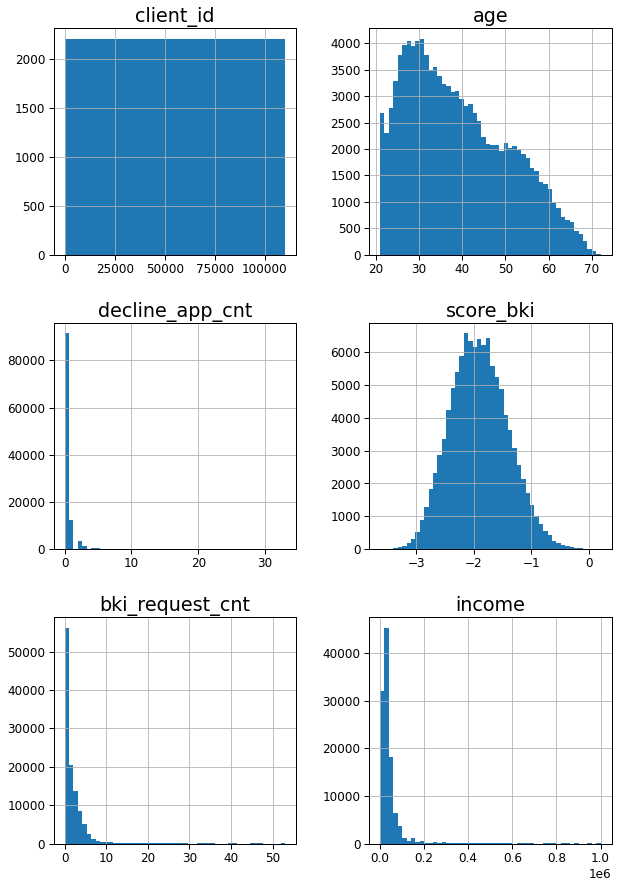

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline

df[num_attr].hist(bins=50, figsize=(10,15));

##### Что можно отметить в данных

- Признак "age" распределен c длинным правым хвостом

- Признак "decline_app_cnt". Большинству клиентов не отказывали в кредитах. Судя по гистограмме есть выбросы. Далее уточним это.

- Признак "bki_request_cnt". Распределение с длинным правым хвостом. Большинство не делали запросов в БКИ. Возможно те, что в "хвосте" либо выбросы, либо очень жадные до БКИ клиенты.

- Признак "score_bki" может быть отрицательным и у него нормальное распределение.

- Признак "income". Доход. Распределение с длинным правых хвостом.
            
Итог:
      
- Признаки имеют разные масштабы. Необходима нормализация 

- Еще у нас есть проблема ввиде расбалансировки классов. Придется применять under/oversmaoling и прочее

- Многие гистограмы имеют длинные хвосты. Это может затруднить алгоритму находить паттерны. Скорее всего тоже дело в нормализации. Нам нужно получать нормальные распределения. Сразу посмотрим, каким численным признакам поможет логорифмирование




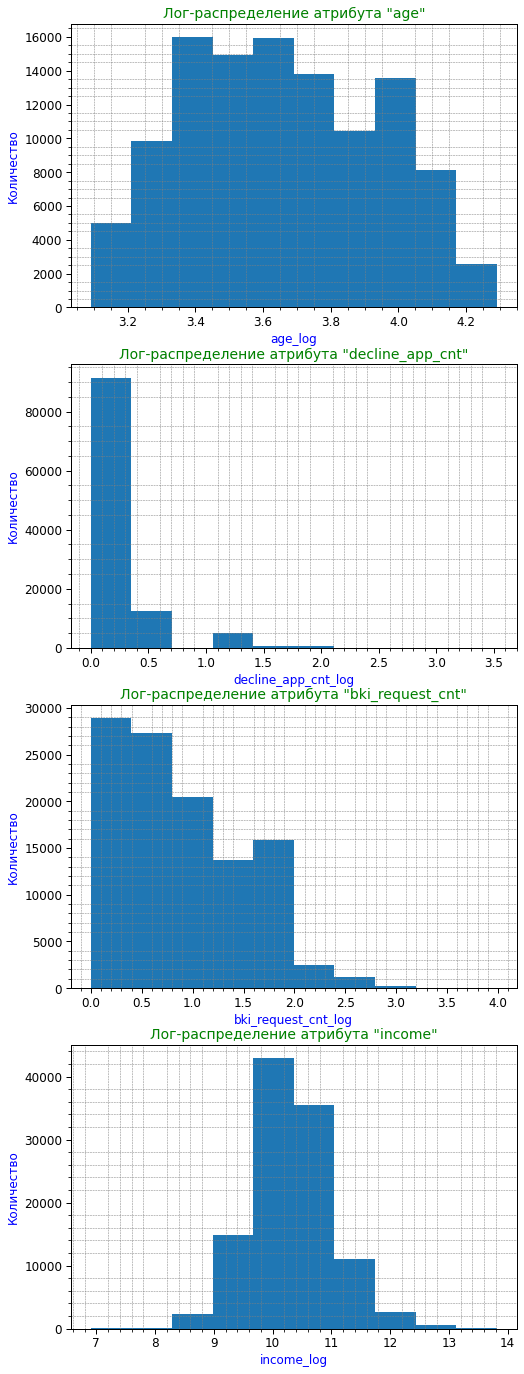

In [103]:
log_and_print(df)

Вывод: В дальнейшем, перед нормализацией, логарифмируем признаки "age" и "income".

<a id='3.2'></a>
### 3.2 Осмотр числовых признаков с помощью бокс-плотов

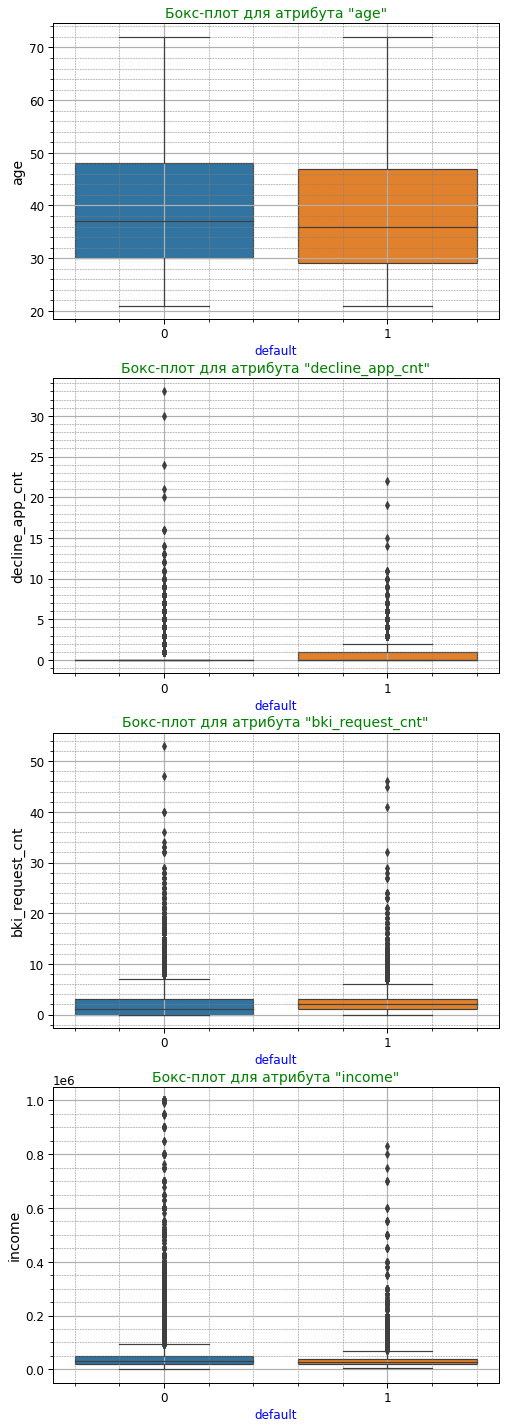

In [104]:
box_plot_print(df)

Вывод: С возрастом все нормально, клиент в 70 лет может брать кридит. У признака income есть выбросы, но они в пределах нормы. То есть доход в 100_000 вполне реален. Не будем трогать этот признак.

Запросить свою кредитную историю (bki_request_cnt) более 50 раз, тоже реально, как и получить 
более 30 отказов. Однако в модель попадет много выбросов. Хороший вариант будет объединить клиентов с высоки мколичеством запросов и отказов о отдельные категории и потом распылить на фиктивные переменные или создать из них категориальные признаки. 

<a id='3.3'></a>
### 3.3 Корреляция числовых признаков

In [105]:
corr_matrix = df[num_attr].corr()
corr_matrix

,client_id,age,decline_app_cnt,score_bki,bki_request_cnt,income
client_id,1.000000,0.015535,-0.021508,-0.061653,-0.027428,-0.002069
age,0.015535,1.000000,-0.111454,-0.104682,0.046975,-0.018664
decline_app_cnt,-0.021508,-0.111454,1.000000,0.187869,0.159927,-0.022241
score_bki,-0.061653,-0.104682,0.187869,1.000000,0.157451,-0.011721
bki_request_cnt,-0.027428,0.046975,0.159927,0.157451,1.000000,0.080475
income,-0.002069,-0.018664,-0.022241,-0.011721,0.080475,1.000000


<AxesSubplot:>

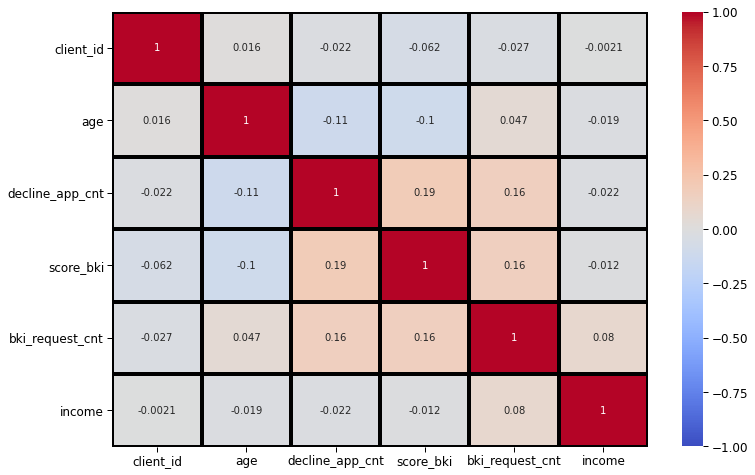

In [106]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1, cmap= 'coolwarm', linewidths=3, linecolor='black')

Сильных корреляций нет. Мультиколлинеарности нет. Слабые до 0.2 корреляции наблюдаются между запросами кредитной истории, скоринговым баллом и отказам по кридиту. 
А также слабая обратная корреляция между возрастом и отказом по кредиту и скоринговым баллом. 

<a id='3.4'></a>
### 3.4 Осмотр категориальных признаков

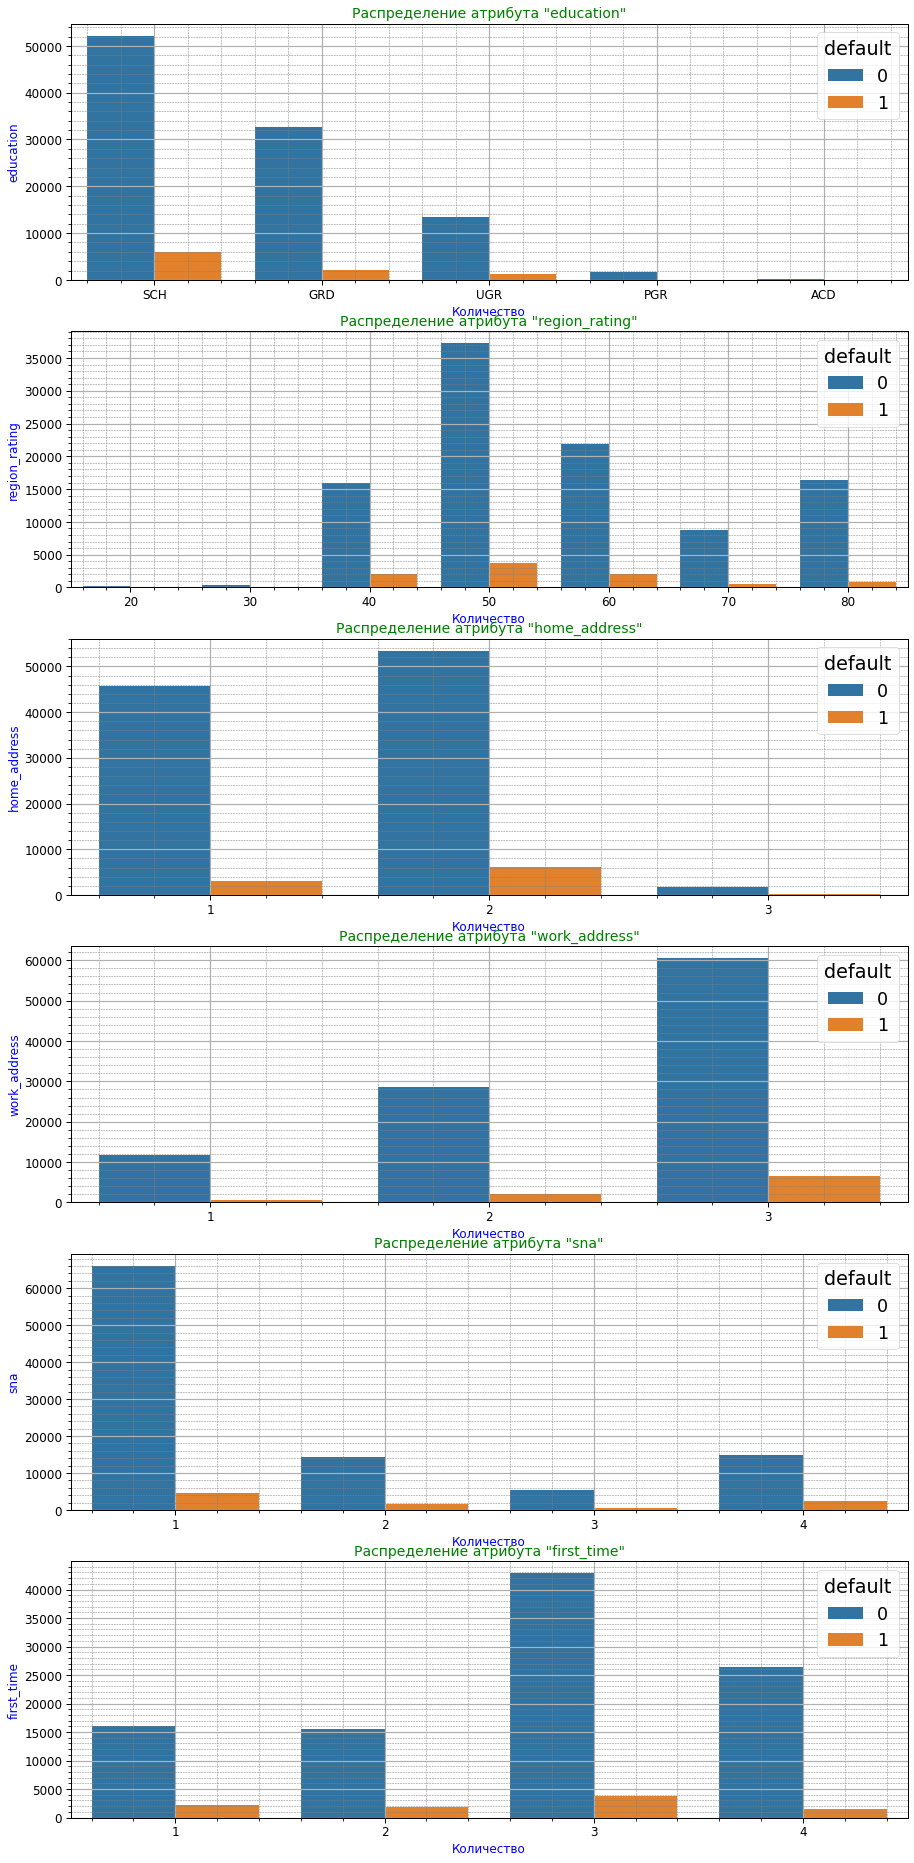

In [107]:
print_cat_attr(df)

Вывод:

- Признак "education' явно имеет зависимость с количеством дефолтных клиентов. Чем выше уровень образования, тем меньше дефолтов.

- Существует и какая-то зависимость дефолтов от региона, но незная что именно означают регионы, что-то точно сказать нельзя.

Остальные признаки визуально выглядят пропорционально

<a id='3.4.1'></a>
#### 3.4.1 Заполнение пропусков у атрибута 'education'

Заменим на самое частое значение - SCH. Скорее всего это сокращение от "School". Используем для этого SimpleImputer из sklearn

In [108]:
from sklearn.impute import SimpleImputer
edu_imputer = SimpleImputer(strategy='most_frequent')
df['education'] = edu_imputer.fit_transform(df[['education']])

In [109]:
df.isnull().sum()

client_id              0
app_date               0
education              0
sex                    0
age                    0
car                    0
car_type               0
decline_app_cnt        0
good_work              0
score_bki              0
bki_request_cnt        0
region_rating          0
home_address           0
work_address           0
income                 0
sna                    0
first_time             0
foreign_passport       0
default                0
train                  0
age_log                0
decline_app_cnt_log    0
bki_request_cnt_log    0
income_log             0
dtype: int64

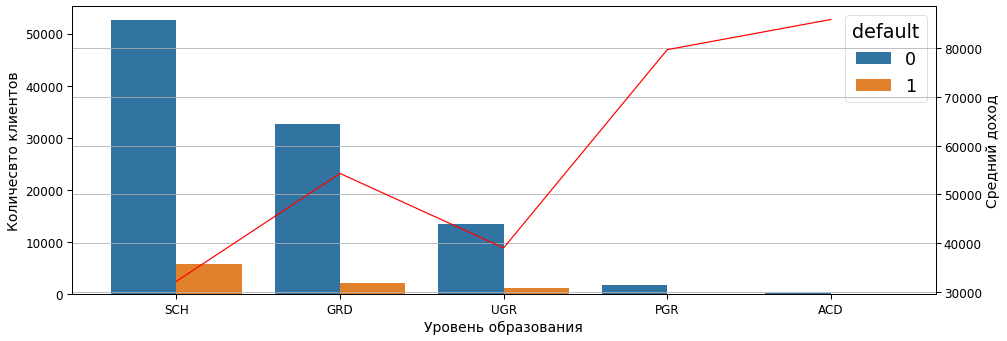

In [110]:
print_def_per_edu(df)

Видна зависимость уровня дохода от образования. Учитывая, что UGR  это урвоень ниже, чем GRD. Поэтому дальше, закодируем этот признак как порядковый категориальный.

<a id='3.5'></a>
### 3.5 Анализ бинарных признаков

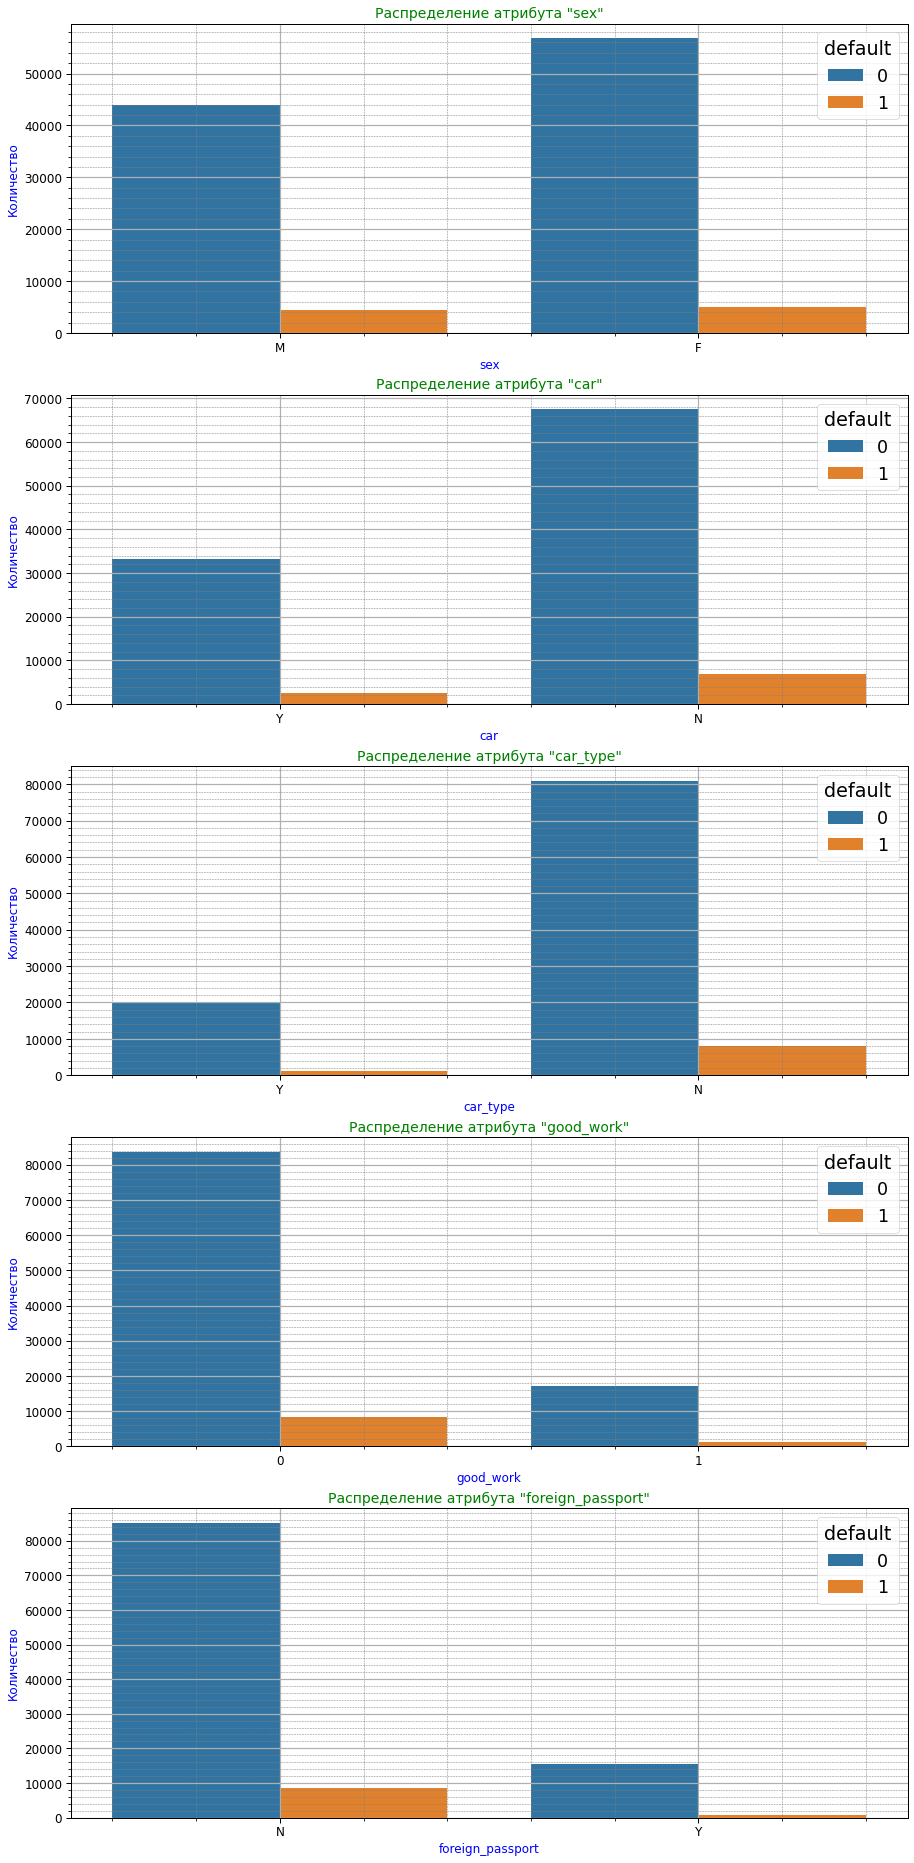

In [111]:
print_bin_attr(df)

Можно отметить следующее:
У кого нет автомобиля, иномарки, загранпаспорта и хорошей работы чаще оказываются дефолтными.

<a id='3.6'></a>
### 3.6 Осмотр признака даты

In [112]:
# конвертируем в тип datetime
df['new_date'] = pd.to_datetime(df['app_date'])
# посмотрим года
display(df['new_date'].dt.year.value_counts())
# посмотрим месяцы
display(df['new_date'].dt.month.value_counts())

2014    110148
Name: new_date, dtype: int64

3    31597
2    27097
4    26266
1    25188
Name: new_date, dtype: int64

Год у нас один. А месяцы это первые 4 месяца года.

In [113]:
df['new_date'] = df['new_date'].dt.month

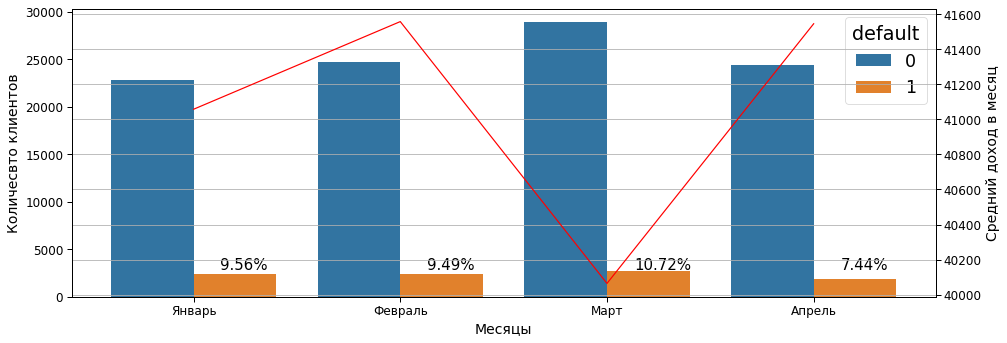

In [114]:
print_def_per_income(df)

Из графика следует, что имеется некоторая зависимость между признанием клиента дефолтным и средним доходом. Можно сделать вывод, что в марте когда средний доход был минимален, был макисмальный процент дефолтных клиентов. Вполне возможно, что это
как-то связано с политическими событиями происходящими в мире в 2014 году...

Здесь нужно решить как в дальнейшем кодировать признак даты. В целом можно было бы присвоить каждому месяцу веса, в зависимости от среднего дохода или количества дефолтных клиентов, но это не будет точным. Мы не знаем, как будет меняться ситуация в дальнешем. Поэтому, оставим это на усмотрение машины и превратим этот признак в фиктивную переменную. 
Но потом. 
Сейчас отнесем его к категориальным признакам

In [115]:
cat_attr.append('new_date')

In [116]:
df

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,sna,first_time,foreign_passport,default,train,age_log,decline_app_cnt_log,bki_request_cnt_log,income_log,new_date
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,...,4,1,N,0,1,4.143135,0.000000,0.693147,9.798183,2
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,...,4,1,N,0,1,4.094345,0.000000,1.386294,9.852247,3
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,...,1,4,Y,0,1,3.258097,1.098612,0.693147,10.308986,2
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,...,1,3,N,0,1,3.988984,0.000000,1.098612,9.210440,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,...,1,4,Y,0,1,3.891820,0.000000,0.693147,10.308986,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,...,4,1,N,0,0,3.637586,0.693147,1.386294,9.615872,3
110144,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,...,1,4,N,0,0,4.174387,0.000000,1.386294,12.206078,4
110145,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,...,4,2,N,0,0,3.465736,1.098612,0.693147,11.002117,3
110146,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,...,1,1,N,0,0,3.332205,0.693147,1.098612,10.308986,1


Уберем признак даты и логорифмированнеые колонки для проверки нормальных распределений.

In [117]:
df.drop(['app_date', 'age_log', 'decline_app_cnt_log', 'bki_request_cnt_log', 'income_log'], axis=1, inplace=True)


##### На данном этапе мы немого преобразили базовый сет. Убрав неинформативные колонки и заполнили пропуски.  Далее создадим копию сета для дальнейших манипуляций и разделим его на train_train, и train_test.


<a id='4'></a>
### 4 Feature Engineering



In [118]:
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,new_date
0,25905,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1,2
1,63161,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1,3
2,25887,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1,2
3,16222,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1,1
4,101655,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1,4


In [119]:
# Логарифмируем доход
attr_adder = logarifmizator(log_age=False)
strat_train_set = attr_adder.transform(df) # не будем логарифмизировать возраст

In [120]:
# Категоризуем
attr_adder = kategorizator()
strat_train_set = attr_adder.transform(df)

In [121]:
# Полимизируем
attr_adder = polymizator()
df = attr_adder.transform(df)

In [122]:
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,income,sna,first_time,foreign_passport,default,train,new_date,age_poly_2,score_bki_poly_2,income_poly_2
0,25905,1,M,62,Y,Y,5,0,-2.008753,5,...,9.798183,4,1,N,0,1,2,3844,4.035088,96.004382
1,63161,1,F,59,N,N,5,0,-1.532276,4,...,9.852247,4,1,N,0,1,3,3481,2.347870,97.066769
2,25887,1,M,25,Y,N,4,0,-1.408142,5,...,10.308986,1,4,Y,0,1,2,625,1.982865,106.275192
3,16222,1,F,53,N,N,5,0,-2.057471,5,...,9.210440,1,3,N,0,1,1,2809,4.233188,84.832212
4,101655,3,M,48,N,N,5,1,-1.244723,5,...,10.308986,1,4,Y,0,1,4,2304,1.549335,106.275192


In [123]:
# Переведем бинарные признаки в 1 и 0, кроме good_work она и так уже 0 и 1
cat_cat = ['sex', 'car', 'car_type', 'foreign_passport']
for col in cat_cat:
    common_encoder = OrdinalEncoder()
    df[col] = common_encoder.fit_transform(df[[col]]).astype('int64')


In [124]:
# Создадим категриальный признак good_life когда есть машина, машина иномарка, хорошая работа и загранник
df['good_life'] = df['car'] + \
                               df['car_type'] + \
                               df['foreign_passport'] + \
                               df['good_work']

In [125]:
cat_attr.append('good_life')

In [126]:
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,sna,first_time,foreign_passport,default,train,new_date,age_poly_2,score_bki_poly_2,income_poly_2,good_life
0,25905,1,1,62,1,1,5,0,-2.008753,5,...,4,1,0,0,1,2,3844,4.035088,96.004382,2
1,63161,1,0,59,0,0,5,0,-1.532276,4,...,4,1,0,0,1,3,3481,2.347870,97.066769,0
2,25887,1,1,25,1,0,4,0,-1.408142,5,...,1,4,1,0,1,2,625,1.982865,106.275192,2
3,16222,1,0,53,0,0,5,0,-2.057471,5,...,1,3,0,0,1,1,2809,4.233188,84.832212,0
4,101655,3,1,48,0,0,5,1,-1.244723,5,...,1,4,1,0,1,4,2304,1.549335,106.275192,2


<a id='4.1'></a>
### 4.1 Матрица корреляций для категориальных признаков

<AxesSubplot:>

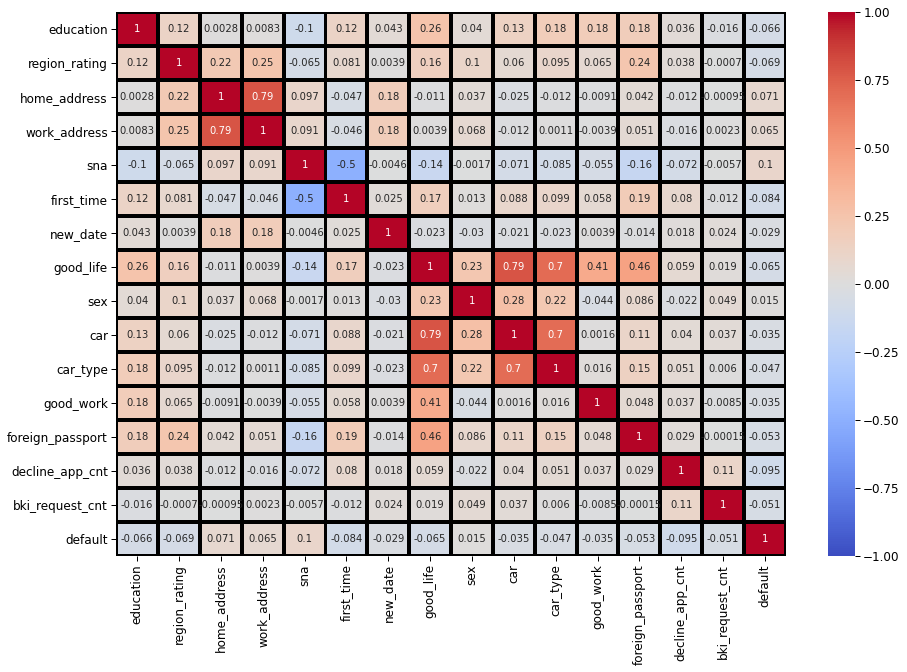

In [127]:
plt.figure(figsize=(15,10))
sns.heatmap(df[cat_attr + bin_attr+['decline_app_cnt', 'bki_request_cnt', 'default']].corr(method='spearman'),
                                            annot=True,
                                            vmin=-1,
                                            vmax=1,
                                            cmap= 'coolwarm',
                                            linewidths=3,
                                            linecolor='black')

Матрица корреляций категориальных признаков, выявила несколько посягательств на мультиколлинеарность.

- Признаки домашний и рабочий адрес коррелируеют между собой очень сиьно. Оставим признак домашнего адреса, так как это недвижимость и скорее всего может рассматриваться как объект залога. А признак рабочий адрес распылим на фиктивные переменные

- Признаки наличия машины и машины иномарки также коррелирую сильно. Оставим признак машины иномарки. 

- Есть корреляция 0.5 между признакми sna и first_time. Но пока оставим их

<a id='4.2'></a>
### 4.2 Оценка важности категориальных переменных

<AxesSubplot:>

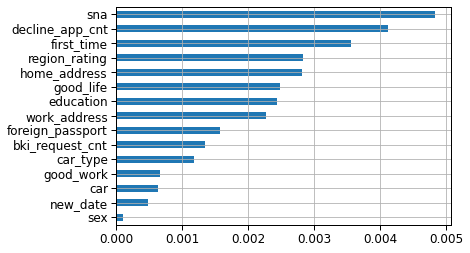

In [128]:
imp_cat = pd.Series(mutual_info_classif(df[cat_attr + bin_attr+['decline_app_cnt', 'bki_request_cnt']], df['default'],
                                     discrete_features =True), index = cat_attr + bin_attr+['decline_app_cnt', 'bki_request_cnt'])
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', grid=True)

Как видно, комбинация признаков больше влияет на таргет. В данном случае признак 'good_life', оказывает большее влияние чем признак 'car_plus'. Но ожидаемо между ними есть зависимость, так, что оставим только признак хорошей жизни. (Зависимость признака хорошей работы и наичия загранника менее 0.5, оставим и их).

Рейтинг региона сократим на 10, так наверное проще дальше для стандартизации

In [129]:
df['region_rating'] = df['region_rating'].apply(lambda x: x/10).astype('int64')

В итоге удалим признаки "work_address", "car", "sex", 'car_ype', 'car_plus'.

In [130]:
df.drop([ "car", 'car_type'], axis=1, inplace=True)

In [131]:
df

,client_id,education,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,...,sna,first_time,foreign_passport,default,train,new_date,age_poly_2,score_bki_poly_2,income_poly_2,good_life
0,25905,1,1,62,5,0,-2.008753,5,5,1,...,4,1,0,0,1,2,3844,4.035088,96.004382,2
1,63161,1,0,59,5,0,-1.532276,4,5,2,...,4,1,0,0,1,3,3481,2.347870,97.066769,0
2,25887,1,1,25,4,0,-1.408142,5,8,1,...,1,4,1,0,1,2,625,1.982865,106.275192,2
3,16222,1,0,53,5,0,-2.057471,5,5,2,...,1,3,0,0,1,1,2809,4.233188,84.832212,0
4,101655,3,1,48,5,1,-1.244723,5,6,2,...,1,4,1,0,1,4,2304,1.549335,106.275192,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,1,0,37,4,0,-1.744976,4,5,2,...,4,1,0,0,0,3,1369,3.044940,92.464997,0
110144,106254,3,0,64,5,0,-2.293781,4,6,1,...,1,4,0,0,0,4,4096,5.261433,148.988331,2
110145,81852,3,1,31,4,0,-0.940752,5,5,1,...,4,2,0,0,0,3,961,0.885014,121.046568,0
110146,1971,2,0,27,4,0,-1.242392,5,8,2,...,1,1,0,0,0,1,729,1.543537,106.275192,0


<a id='4.3'></a>
### 4.3 Оценка важности численных переменных

In [132]:
num_attr = ['age', 'score_bki', 'first_time', 'home_address', 'income_poly_2']

<AxesSubplot:>

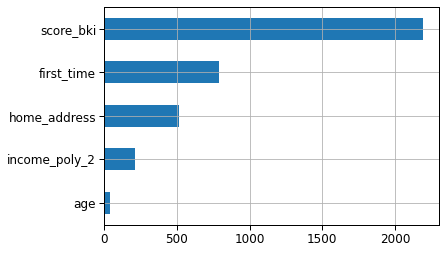

In [133]:
imp_num = pd.Series(f_classif(df[num_attr],
                              df['default'])[0],
                              index = num_attr)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', grid=True)

In [134]:
#corr_matrix = df[num_attr].corr()
##plt.figure(figsize=(12, 8))
#sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1, cmap= 'coolwarm', linewidths=3, linecolor='black')

In [135]:
df.drop(['income', 'age_poly_2', 'score_bki_poly_2'], axis=1, inplace=True)

In [136]:
df

,client_id,education,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,sna,first_time,foreign_passport,default,train,new_date,income_poly_2,good_life
0,25905,1,1,62,5,0,-2.008753,5,5,1,2,4,1,0,0,1,2,96.004382,2
1,63161,1,0,59,5,0,-1.532276,4,5,2,3,4,1,0,0,1,3,97.066769,0
2,25887,1,1,25,4,0,-1.408142,5,8,1,2,1,4,1,0,1,2,106.275192,2
3,16222,1,0,53,5,0,-2.057471,5,5,2,3,1,3,0,0,1,1,84.832212,0
4,101655,3,1,48,5,1,-1.244723,5,6,2,3,1,4,1,0,1,4,106.275192,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,1,0,37,4,0,-1.744976,4,5,2,3,4,1,0,0,0,3,92.464997,0
110144,106254,3,0,64,5,0,-2.293781,4,6,1,2,1,4,0,0,0,4,148.988331,2
110145,81852,3,1,31,4,0,-0.940752,5,5,1,2,4,2,0,0,0,3,121.046568,0
110146,1971,2,0,27,4,0,-1.242392,5,8,2,3,1,1,0,0,0,1,106.275192,0


<a id='4.4'></a>
### 4.4 Cтандартизируем числовые, и превращаем в фиктивные переменные категориальные признаки

In [137]:
norm_attr = ['education',
              'age',
              'decline_app_cnt',
              'score_bki',
              'bki_request_cnt',              
              'region_rating',              
              'first_time',
              'income_poly_2',
              'good_life']
dummy_attr = ['education', 'new_date', 'work_address','sna' ]
              
              
norma_attr_2 = [
              'age',
              'decline_app_cnt',
              'score_bki',
              'bki_request_cnt',
              'income',
              'region_rating',
              'sna',
              
              'age_poly_2',
              'score_bki_poly_2',
              'income_poly_2',
              'good_life']
dummy_attr_2 = ['education', 'new_date', 'home_address', 'first_time',]

In [138]:
normalizator = StandardScaler()
for column in norm_attr:
    df[column] = normalizator.fit_transform(df[[column]])

In [139]:
df

,client_id,education,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,sna,first_time,foreign_passport,default,train,new_date,income_poly_2,good_life
0,25905,-0.867437,1,1.975219,0.423486,0,-0.208688,0.607329,-0.516704,1,2,4,-1.747836,0,0,1,2,-0.788116,1.174570
1,63161,-0.867437,0,1.714757,0.423486,0,0.745419,-1.149535,-0.516704,2,3,4,-1.747836,0,0,1,3,-0.715412,-0.834819
2,25887,-0.867437,1,-1.237142,-1.752378,0,0.993988,0.607329,1.779355,1,2,1,1.222031,1,0,1,2,-0.085236,1.174570
3,16222,-0.867437,0,1.193834,0.423486,0,-0.306243,0.607329,-0.516704,2,3,1,0.232075,0,0,1,1,-1.552680,-0.834819
4,101655,1.231494,1,0.759731,0.423486,1,1.321223,0.607329,0.248649,2,3,1,1.222031,1,0,1,4,-0.085236,1.174570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,-0.867437,0,-0.195295,-1.752378,0,0.319505,-1.149535,-0.516704,2,3,4,-1.747836,0,0,0,3,-1.030333,-0.834819
110144,106254,1.231494,0,2.148860,0.423486,0,-0.779436,-1.149535,0.248649,1,2,1,1.222031,0,0,0,4,2.837823,1.174570
110145,81852,1.231494,1,-0.716218,-1.752378,0,1.929901,0.607329,-0.516704,1,2,4,-0.757880,0,0,0,3,0.925638,-0.834819
110146,1971,0.182028,0,-1.063501,-1.752378,0,1.325890,0.607329,1.779355,2,3,1,-1.747836,0,0,0,1,-0.085236,-0.834819


In [140]:
df = pd.get_dummies(df, columns=dummy_attr)

In [141]:
df

,client_id,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,first_time,...,new_date_2,new_date_3,new_date_4,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4
0,25905,1,1.975219,0.423486,0,-0.208688,0.607329,-0.516704,1,-1.747836,...,1,0,0,0,1,0,0,0,0,1
1,63161,0,1.714757,0.423486,0,0.745419,-1.149535,-0.516704,2,-1.747836,...,0,1,0,0,0,1,0,0,0,1
2,25887,1,-1.237142,-1.752378,0,0.993988,0.607329,1.779355,1,1.222031,...,1,0,0,0,1,0,1,0,0,0
3,16222,0,1.193834,0.423486,0,-0.306243,0.607329,-0.516704,2,0.232075,...,0,0,0,0,0,1,1,0,0,0
4,101655,1,0.759731,0.423486,1,1.321223,0.607329,0.248649,2,1.222031,...,0,0,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,0,-0.195295,-1.752378,0,0.319505,-1.149535,-0.516704,2,-1.747836,...,0,1,0,0,0,1,0,0,0,1
110144,106254,0,2.148860,0.423486,0,-0.779436,-1.149535,0.248649,1,1.222031,...,0,0,1,0,1,0,1,0,0,0
110145,81852,1,-0.716218,-1.752378,0,1.929901,0.607329,-0.516704,1,-0.757880,...,0,1,0,0,1,0,0,0,0,1
110146,1971,0,-1.063501,-1.752378,0,1.325890,0.607329,1.779355,2,-1.747836,...,0,0,0,0,0,1,1,0,0,0


In [142]:
# Разделим обратно на train и test
train = df.query('train == 1').drop(['train'], axis=1)
test = df.query('train == 0').drop(['train'], axis=1)

In [143]:
# удалим для X целевую переменную и client_id
X = train.drop(columns = ['default', 'client_id'])
Y = train['default']

<a id='5'></a>
### 5 Выбор модели ML

<a id='5.1'></a>
### 5.1 Простая модель. 

- алгоритм: лог.регрессия

- метод избавления от дисбаланса классов: отсуствует 

In [144]:
# При таком разделении результат лучше, чем при StratifiedShuffleSplit
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = RS, test_size=0.2)

##### 5.1.1 Обучение

In [145]:
Model_1 = LogisticRegression(max_iter=1000, random_state=RS)


Model_1.fit(X_train, y_train)
#Значения
y_pred_1 = Model_1.predict(X_test)
# Вероятности
y_pred_probs_1 = Model_1.predict_proba(X_test)

# Посчитаем показатели для обучающего набора, что бы следить за переобучением
#Значения
y_pred_1_train = Model_1.predict(X_train)
# Вероятности
y_pred_probs_1_train = Model_1.predict_proba(X_train)
 
# Для кривой порога
y_scores = cross_val_predict(Model_1, X_train, y_train, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

##### 5.1.2 Матрица ошибок модели 1

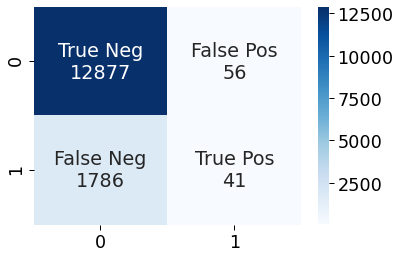

In [146]:
print_CM(y_test, y_pred_1)

##### 5.1.3 Отрисовка порога

(-5.0, 2.0, 0.0, 1.0)

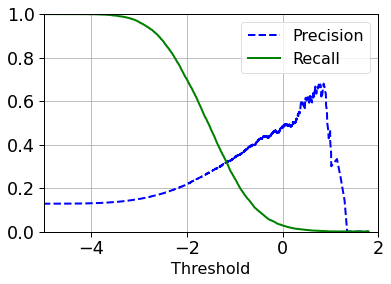

In [147]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="upper right", fontsize=16) 
plt.xlabel("Threshold", fontsize=16)        
plt.grid(True)                              
plt.axis([-5, 2, 0, 1])             

Тут можно заметить, что сильно мешает разбалансировка классов.

##### 5.1.4 Оценка точность/полнота 

Точность - 0.423
Полнота - 0.022
F1 мера - 0.043


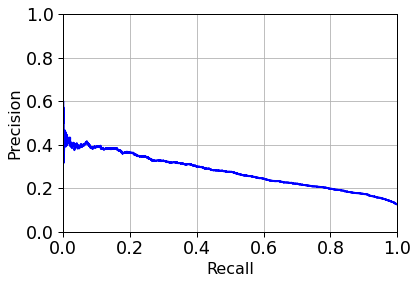

In [148]:
print_all_score(y_test, y_pred_1, y_pred_probs_1)

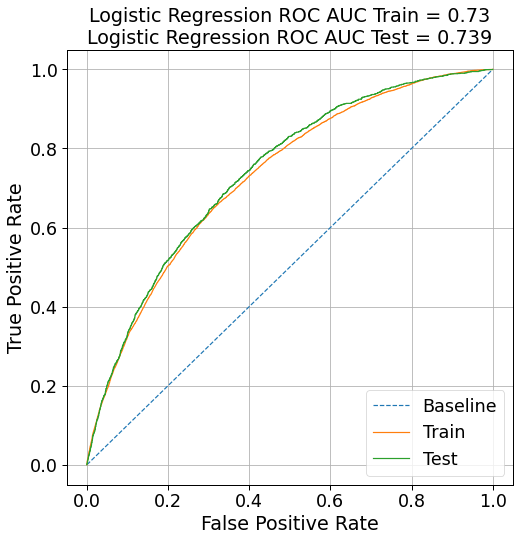

In [149]:
print_ROC_AUC(y_train, y_pred_probs_1_train, y_test, y_pred_probs_1)

In [150]:
Mod1 = model_compare('Модель 1', 'Лог.рег', 'Нет', y_test, y_pred_1, y_pred_probs_1, new=True )

In [151]:
Models = Mod1
Models

,Модель,Алгоритм,Баланс,Точность,Полнота,F1 мера,ROC AUC
0,Модель 1,Лог.рег,Нет,0.423,0.022,0.043,0.738577


Из-за дисбаланса полнота очень низкая

<a id='5.2'></a>
### 5.2 Модель 2.

- алгоритм: лог.регрессия

- метод избавления от дисбаланса классов: class_weight = 'Balanced'

##### 5.2.1 Обучение

In [152]:
Model_2 = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RS, )


Model_2.fit(X_train, y_train)
#Значения
y_pred_2 = Model_2.predict(X_test)
# Вероятности
y_pred_probs_2 = Model_2.predict_proba(X_test)

# Посчитаем показатели для обучающего набора, что бы следить за переобучением
#Значения
y_pred_2_train = Model_2.predict(X_train)
# Вероятности
y_pred_probs_2_train = Model_2.predict_proba(X_train)
 
# Для кривой порога
y_scores_2 = cross_val_predict(Model_2, X_train, y_train, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_2)

##### 5.2.2 Матрица ошибок

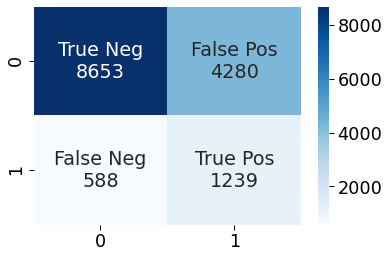

In [153]:
print_CM(y_test, y_pred_2)

##### 5.2.3 Отрисовка порога 

(-3.0, 3.0, 0.0, 1.0)

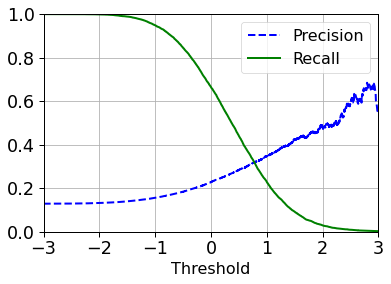

In [154]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="upper right", fontsize=16) 
plt.xlabel("Threshold", fontsize=16)       
plt.grid(True)                              
plt.axis([-3, 3, 0, 1])            

##### 5.2.4 Оценка точность/полнота

Точность - 0.224
Полнота - 0.678
F1 мера - 0.337


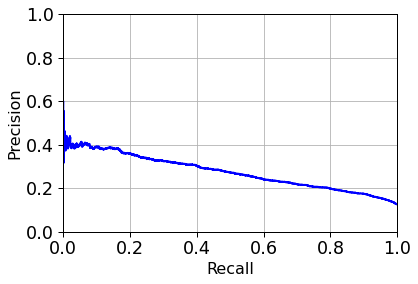

In [155]:
print_all_score(y_test, y_pred_2, y_pred_probs_2)

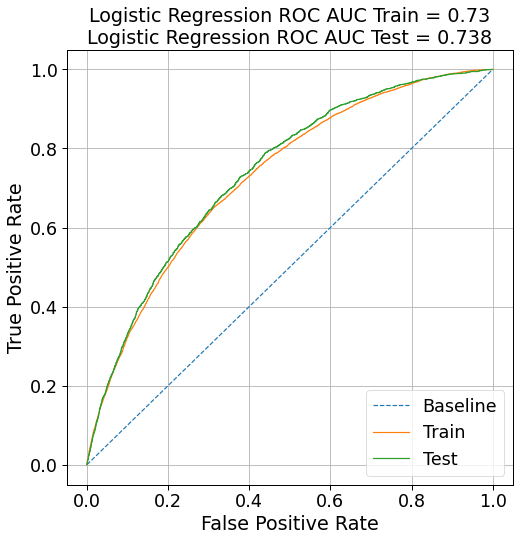

In [156]:
print_ROC_AUC(y_train, y_pred_probs_2_train, y_test, y_pred_probs_2)

In [157]:
Mod2 = model_compare('Модель 2', 'Лог.рег', 'balanced', y_test, y_pred_2, y_pred_probs_2)
Models = pd.concat([Models, Mod2], ignore_index=True, axis=0)
Models

,Модель,Алгоритм,Баланс,Точность,Полнота,F1 мера,ROC AUC
0,Модель 1,Лог.рег,Нет,0.423,0.022,0.043,0.738577
1,Модель 2,Лог.рег,balanced,0.224,0.678,0.337,0.738398


С применением балансировки точность модели упала, но значительно выросла полнота. Иными словами почти 70% клиентов, которые не смогут выплатить кредит его не получат, но будут страдать и те, кто кредит выплатит, однако неполучит его. 
Переобучения в данном случае нет.

<a id='5.3'></a>
### 5.3 Модель 3

- алгоритм: лог.регрессия

- метод избавления от дисбаланса классов: настроен вручную

##### 5.3.1 Обучение

In [158]:
# Баланс выбирался вручную на основе матрицы ошибок. Выбирлся тот где F1 мера лучше, чем у модели 2.
balance = {0:0.2, 1:0.8}

In [159]:
Model_3 = LogisticRegression(max_iter=1000, class_weight=balance, random_state=RS, )

Model_3.fit(X_train, y_train)
#Значения
y_pred_3 = Model_3.predict(X_test)
# Вероятности
y_pred_probs_3 = Model_3.predict_proba(X_test)

# Посчитаем показатели для обучающего набора, что бы следить за переобучением
#Значения
y_pred_3_train = Model_3.predict(X_train)
# Вероятности
y_pred_probs_3_train = Model_3.predict_proba(X_train)
 
# Для кривой порога
y_scores_3 = cross_val_predict(Model_3, X_train, y_train, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_3) 

##### 5.3.2 Матрица ошибок

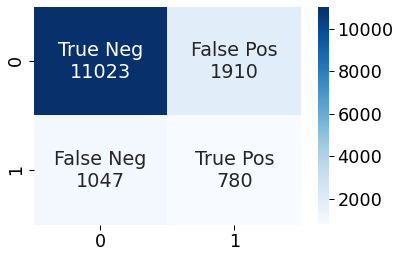

In [160]:
print_CM(y_test, y_pred_3)

##### 5.3.3 Отрисовка порога

(-3.0, 3.0, 0.0, 1.0)

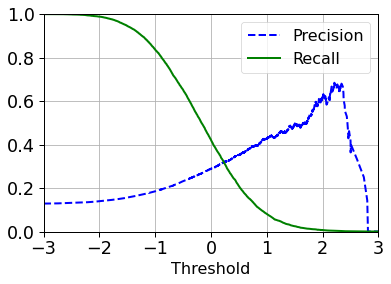

In [161]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="upper right", fontsize=16) 
plt.xlabel("Threshold", fontsize=16)       
plt.grid(True)                              
plt.axis([-3, 3, 0, 1])            

##### 5.3.4 Оценка точность/полнота

Точность - 0.29
Полнота - 0.427
F1 мера - 0.345


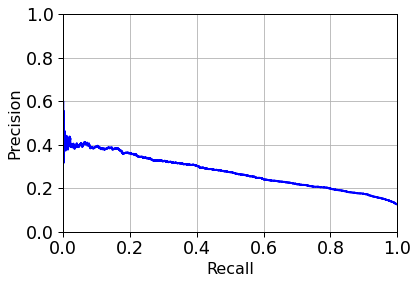

In [162]:
print_all_score(y_test, y_pred_3, y_pred_probs_3)

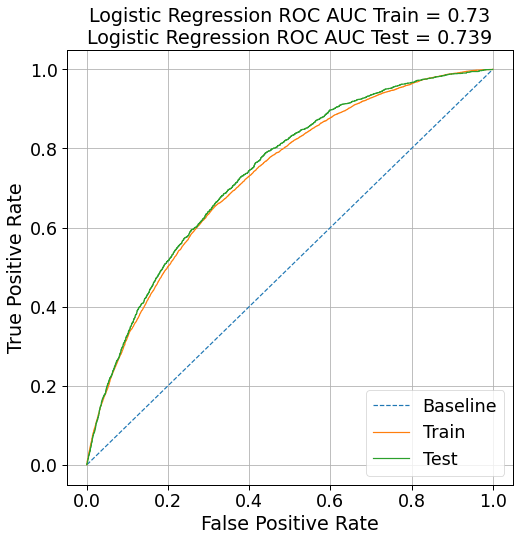

In [163]:
print_ROC_AUC(y_train, y_pred_probs_3_train, y_test, y_pred_probs_3)

In [164]:
Mod3 = model_compare('Модель 3', 'Лог.рег', '0:0.2, 1:0.8', y_test, y_pred_3, y_pred_probs_3)
Models = pd.concat([Models, Mod3], ignore_index=True,axis=0)
Models

,Модель,Алгоритм,Баланс,Точность,Полнота,F1 мера,ROC AUC
0,Модель 1,Лог.рег,Нет,0.423,0.022,0.043,0.738577
1,Модель 2,Лог.рег,balanced,0.224,0.678,0.337,0.738398
2,Модель 3,Лог.рег,"0:0.2, 1:0.8",0.290,0.427,0.345,0.738501


Повысили точность, за счет полноты, F1 мера стала лучше, чем при балансировке с помощью balanced. А ROC-AUC стала выше. 

<a id='5.4'></a>
### 5.4 Поиск оптимальных параметров для моделей лог.регресии

- алгоритм: лог.регрессия

- поиск параметров с помощью GridSearchCV (баланс, решатель, регуляризация и т.д.)

In [165]:
balance

{0: 0.2, 1: 0.8}

##### Обучение

Сейчас поищем лучшие парметры для модель ореентирующуюся на лучшее значение F1 меры. То есть для решения бизнес задачи. 

In [80]:
%%time
model_BP = LogisticRegression(max_iter=1000, random_state=RS)
param_grid = [
    {
     'penalty': ['l1'],
     
     'solver': ['liblinear'], 
     'class_weight':[None, 'balanced', balance]}, 
    {
     'penalty': ['l2'],
     
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':[None, 'balanced', balance]}, 
    {
     'penalty': ['none'],
     
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':[None, 'balanced', balance]} 
]


gridsearch = GridSearchCV(model_BP, param_grid, scoring='f1', n_jobs=-1, error_score='raise')
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
## печатаем параметры
best_parameters = model.get_params()
for param_name in best_parameters:
        print(param_name, best_parameters[param_name], '\n')


C 1.0 

class_weight {0: 0.2, 1: 0.8} 

dual False 

fit_intercept True 

intercept_scaling 1 

l1_ratio None 

max_iter 1000 

multi_class auto 

n_jobs None 

penalty l2 

random_state 42 

solver liblinear 

tol 0.0001 

verbose 0 

warm_start False 

Wall time: 1min 21s


##### 5.4.1 Посмотрим на модель с лучшими параметрами

In [167]:
Model_4_1 = LogisticRegression(C=1,
                              class_weight=balance,
                              dual=False,
                              fit_intercept=True,
                              intercept_scaling=1,
                              l1_ratio=None,
                              max_iter=1000,
                              multi_class='auto',
                              n_jobs= None,
                              penalty='l2',
                              random_state=RS,
                              solver='liblinear',
                              tol = 0.0001,
                              verbose=0,
                              warm_start=False)

Model_4_1.fit(X_train, y_train)
#Значения
y_pred_4_1 = Model_4_1.predict(X_test)
# Вероятности
y_pred_probs_4_1 = Model_4_1.predict_proba(X_test)

# Посчитаем показатели для обучающего набора, что бы следить за переобучением
#Значения
y_pred_4_1_train = Model_4_1.predict(X_train)
# Вероятности
y_pred_probs_4_1_train = Model_4_1.predict_proba(X_train)

# Для кривой порога
y_scores_4_1 = cross_val_predict(Model_4_1, X_train, y_train, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_4_1)

##### 5.4.2 Матрица ошибок

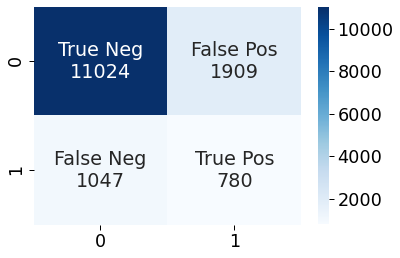

In [168]:
print_CM(y_test, y_pred_4_1)

##### 5.4.3 Отрисовка порога 


(-3.0, 3.0, 0.0, 1.0)

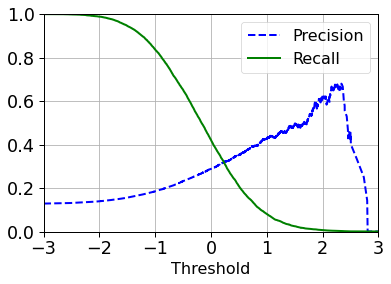

In [169]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="upper right", fontsize=16) 
plt.xlabel("Threshold", fontsize=16)       
plt.grid(True)                              
plt.axis([-3, 3, 0, 1])            

##### 5.4.4 Оценка точность/полнота

Точность - 0.29
Полнота - 0.427
F1 мера - 0.345


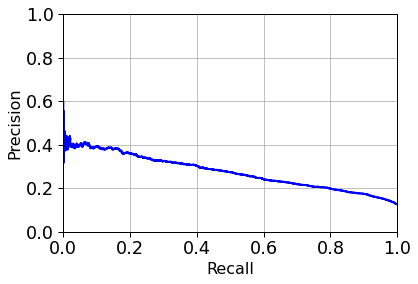

In [170]:
print_all_score(y_test, y_pred_4_1, y_pred_probs_4_1)

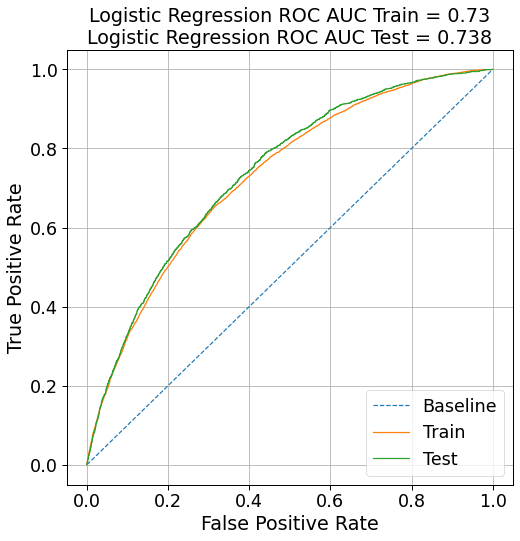

In [171]:
print_ROC_AUC(y_train, y_pred_probs_4_1_train, y_test, y_pred_probs_4_1)

In [172]:
Mod4_1 = model_compare('Модель 4_1', 'Лог.рег (Парам_1)', '0:0.2, 1:0.8', y_test, y_pred_4_1, y_pred_probs_4_1)
Models = pd.concat([Models, Mod4_1], ignore_index=True,axis=0)
Models

,Модель,Алгоритм,Баланс,Точность,Полнота,F1 мера,ROC AUC
0,Модель 1,Лог.рег,Нет,0.423,0.022,0.043,0.738577
1,Модель 2,Лог.рег,balanced,0.224,0.678,0.337,0.738398
2,Модель 3,Лог.рег,"0:0.2, 1:0.8",0.290,0.427,0.345,0.738501
3,Модель 4_1,Лог.рег (Парам_1),"0:0.2, 1:0.8",0.290,0.427,0.345,0.738498


Модель 3 отработала лучше

Сейчас поищем лучшие парметры для модель ореентирующуюся на лучшее значение ROC AUC.

In [255]:
%%time
C = np.logspace(0, 4, 10)
model_BP_1 = LogisticRegression(max_iter=1000, random_state=RS)
param_grid = [
    {
     'penalty': ['l1'],
     'C': C,
     'solver': ['liblinear'], 
     'class_weight':[None, 'balanced', balance]}, 
    {
     'penalty': ['l2'],
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':[None, 'balanced', balance]}, 
    {
     'penalty': ['none'],
     
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':[None, 'balanced', balance]} 
]


gridsearch = GridSearchCV(model_BP_1, param_grid, scoring='roc_auc', n_jobs=-1, error_score='raise')
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
## печатаем параметры
best_parameters = model.get_params()
for param_name in best_parameters:
        print(param_name, best_parameters[param_name], '\n')


C 1.0 

class_weight {0: 0.2, 1: 0.8} 

dual False 

fit_intercept True 

intercept_scaling 1 

l1_ratio None 

max_iter 1000 

multi_class auto 

n_jobs None 

penalty l2 

random_state 42 

solver liblinear 

tol 0.0001 

verbose 0 

warm_start False 

Wall time: 27min 27s


##### 5.4.5 Посмотрим на модель с такими параметрами

In [173]:
Model_4_2 = LogisticRegression(C=1,
                              class_weight=balance,
                              dual=False,
                              fit_intercept=True,
                              intercept_scaling=1,
                              l1_ratio=None,
                              max_iter=1000,
                              multi_class='auto',
                              n_jobs= None,
                              penalty='l2',
                              random_state=RS,
                              solver='liblinear',
                              tol = 0.0001,
                              verbose=0,
                              warm_start=False)

Model_4_2.fit(X_train, y_train)
#Значения
y_pred_4_2 = Model_4_2.predict(X_test)
# Вероятности
y_pred_probs_4_2 = Model_4_2.predict_proba(X_test)

# Посчитаем показатели для обучающего набора, что бы следить за переобучением
#Значения
y_pred_4_2_train = Model_4_2.predict(X_train)
# Вероятности
y_pred_probs_4_2_train = Model_4_2.predict_proba(X_train)

# Для кривой порога
y_scores_4_2 = cross_val_predict(Model_4_2, X_train, y_train, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_4_2)

##### 5.4.6 Матрица ошибок модели 4_2

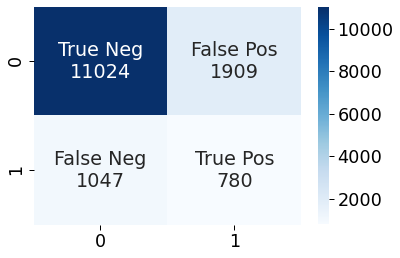

In [174]:
print_CM(y_test, y_pred_4_2)

##### 5.4.7 Отрисовка порога (модель 4_2)


(-3.0, 3.0, 0.0, 1.0)

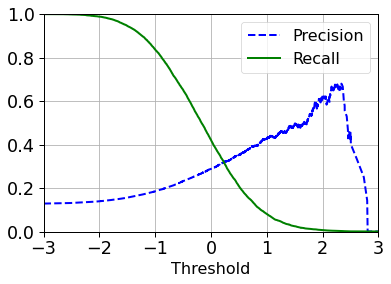

In [175]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="upper right", fontsize=16) 
plt.xlabel("Threshold", fontsize=16)       
plt.grid(True)                              
plt.axis([-3, 3, 0, 1])            

##### 5.4.8 Оценка точность/полнота (модель 4_2)

Точность - 0.29
Полнота - 0.427
F1 мера - 0.345


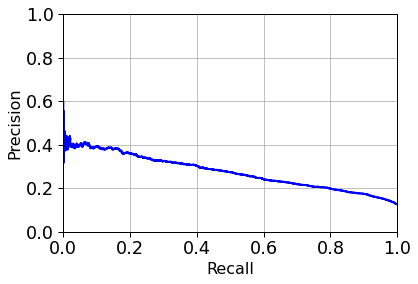

In [176]:
print_all_score(y_test, y_pred_4_2, y_pred_probs_4_2)

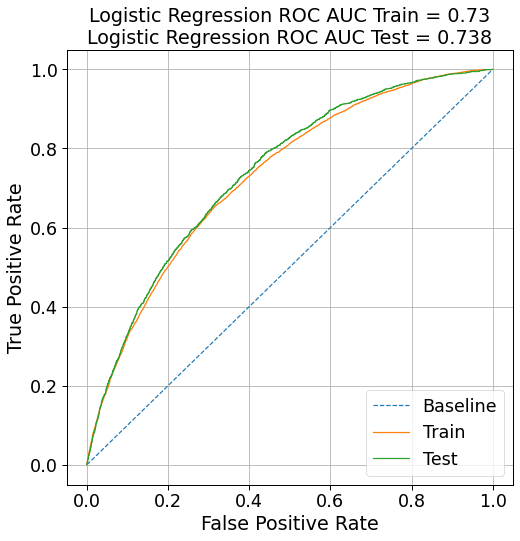

In [177]:
print_ROC_AUC(y_train, y_pred_probs_4_2_train, y_test, y_pred_probs_4_2)

In [178]:
Mod4_2 = model_compare('Модель 4_2', 'Лог.рег (Парам_2)', '0:0.2, 1:0.8', y_test, y_pred_4_2, y_pred_probs_4_2)
Models = pd.concat([Models, Mod4_2], ignore_index=True,axis=0)
Models

,Модель,Алгоритм,Баланс,Точность,Полнота,F1 мера,ROC AUC
0,Модель 1,Лог.рег,Нет,0.423,0.022,0.043,0.738577
1,Модель 2,Лог.рег,balanced,0.224,0.678,0.337,0.738398
2,Модель 3,Лог.рег,"0:0.2, 1:0.8",0.290,0.427,0.345,0.738501
3,Модель 4_1,Лог.рег (Парам_1),"0:0.2, 1:0.8",0.290,0.427,0.345,0.738498
4,Модель 4_2,Лог.рег (Парам_2),"0:0.2, 1:0.8",0.290,0.427,0.345,0.738498


<a id='5.5'></a>
### 5.5  Модель 5


- алгоритм: catboost

In [179]:
from catboost import CatBoostClassifier
Model_5 = CatBoostClassifier(n_estimators=1000, depth=2, class_weights=balance, logging_level='Silent')


Model_5.fit(X_train, y_train)
#Значения
y_pred_5 = Model_5.predict(X_test)
# Вероятности
y_pred_probs_5 = Model_5.predict_proba(X_test)

# Посчитаем показатели для обучающего набора, что бы следить за переобучением
#Значения
y_pred_5_train = Model_5.predict(X_train)
# Вероятности
y_pred_probs_5_train = Model_5.predict_proba(X_train)

# Для кривой порога
y_scores_5 = cross_val_predict(Model_5, X_train, y_train, cv=3)
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_5)

##### 5.5.1 Матрица ошибок

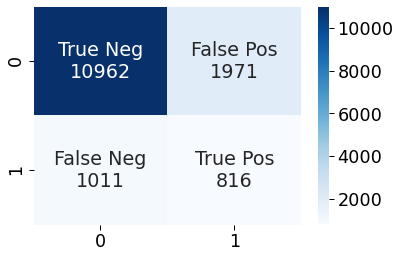

In [180]:
print_CM(y_test, y_pred_5)

##### 5.5.2 Оценка точность/полнота

Точность - 0.293
Полнота - 0.447
F1 мера - 0.354


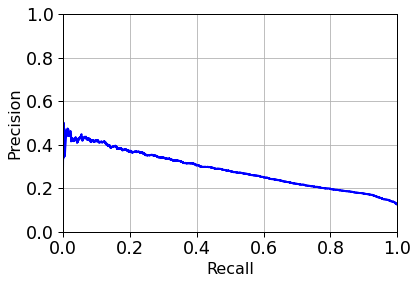

In [181]:
print_all_score(y_test, y_pred_5, y_pred_probs_5)

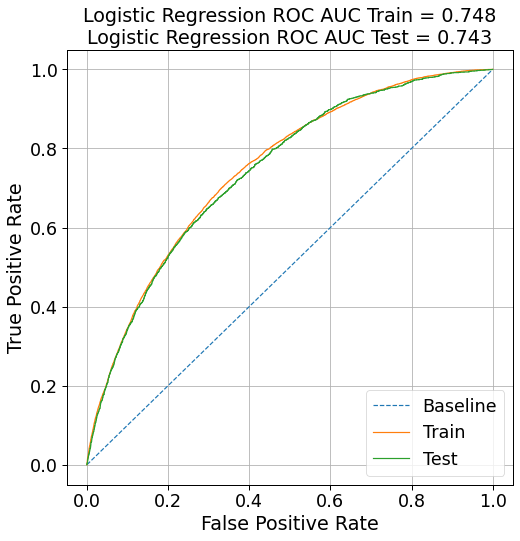

In [182]:
print_ROC_AUC(y_train, y_pred_probs_5_train, y_test, y_pred_probs_5)

In [183]:
Mod4_2 = model_compare('Модель 5', 'Catboost', '0:0.2, 1:0.8', y_test, y_pred_5, y_pred_probs_5)
Models = pd.concat([Models, Mod4_2], ignore_index=True,axis=0)
Models

,Модель,Алгоритм,Баланс,Точность,Полнота,F1 мера,ROC AUC
0,Модель 1,Лог.рег,Нет,0.423,0.022,0.043,0.738577
1,Модель 2,Лог.рег,balanced,0.224,0.678,0.337,0.738398
2,Модель 3,Лог.рег,"0:0.2, 1:0.8",0.290,0.427,0.345,0.738501
3,Модель 4_1,Лог.рег (Парам_1),"0:0.2, 1:0.8",0.290,0.427,0.345,0.738498
4,Модель 4_2,Лог.рег (Парам_2),"0:0.2, 1:0.8",0.290,0.427,0.345,0.738498
5,Модель 5,Catboost,"0:0.2, 1:0.8",0.293,0.447,0.354,0.742943


Модель 5 имеет лучшие показатели среди всех моеделей. 

Далее будем использовать модель 5 и Модель 3 (высокий F1 и более менее норм ROC AUC)

In [184]:
# предсказание на тестовой модели и подготовка данных для сабмишн
Model_5.fit(X, Y) # Учим на всем сете
X_test_1 = test.drop(columns = ['default', 'client_id'])
y_probs = Model_5.predict_proba(X_test_1)[:,1]

In [185]:
test['default'] = y_probs

In [186]:
submission = test[['client_id','default']]
display(submission.sample(10))
display(submission.shape)

,client_id,default
95701,73897,0.354897
78217,81874,0.173030
102659,87393,0.140228
91468,65711,0.406259
94850,99202,0.179822
105888,70337,0.220381
102257,59976,0.473767
83928,74009,0.067558
101070,98022,0.040054
86409,106398,0.428431


(36349, 2)

In [187]:
submission.to_csv('submission.csv', index=False)

<a id='6'></a>
# 6 Передискретизация

In [188]:
test_for_samp = train.copy()
test_for_samp

,client_id,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,first_time,...,new_date_2,new_date_3,new_date_4,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4
0,25905,1,1.975219,0.423486,0,-0.208688,0.607329,-0.516704,1,-1.747836,...,1,0,0,0,1,0,0,0,0,1
1,63161,0,1.714757,0.423486,0,0.745419,-1.149535,-0.516704,2,-1.747836,...,0,1,0,0,0,1,0,0,0,1
2,25887,1,-1.237142,-1.752378,0,0.993988,0.607329,1.779355,1,1.222031,...,1,0,0,0,1,0,1,0,0,0
3,16222,0,1.193834,0.423486,0,-0.306243,0.607329,-0.516704,2,0.232075,...,0,0,0,0,0,1,1,0,0,0
4,101655,1,0.759731,0.423486,1,1.321223,0.607329,0.248649,2,1.222031,...,0,0,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,0,0.499269,0.423486,0,0.225214,-1.149535,-0.516704,1,1.222031,...,0,1,0,0,1,0,0,0,0,1
73795,76821,1,0.151987,0.423486,0,-0.307360,0.607329,-0.516704,2,1.222031,...,0,1,0,0,1,0,1,0,0,0
73796,103695,1,-0.716218,0.423486,0,0.784750,-1.149535,1.779355,2,-0.757880,...,0,0,1,0,0,1,0,1,0,0
73797,861,0,-0.889859,0.423486,1,0.851432,-1.149535,-0.516704,1,0.232075,...,0,0,0,0,0,1,0,1,0,0


<a id='6.1'></a>
### 6.1 Применение Undersampling

In [189]:
num_0 = len(test_for_samp[test_for_samp['default']==0])
num_1 = len(test_for_samp[test_for_samp['default']==1])
print(num_0, num_1)

64427 9372


In [190]:
# Убавим класс 0 до уровня класса 1
undersampled_data = pd.concat([test_for_samp[test_for_samp['default']==0].sample(num_1),
                               test_for_samp[test_for_samp['default']==1]])

In [191]:
print(len(undersampled_data))

18744


##### Проверка на модели 3 и модели 5.

In [192]:
# удалим для X целевую переменную и client_id
X_und = undersampled_data.drop(columns = ['default', 'client_id'])
Y_und = undersampled_data['default']

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X_und, Y_und, random_state = RS, test_size=0.2)

In [194]:
# Модель 3
Model_3.fit(X_train, y_train)
#Значения
y_pred_3U = Model_3.predict(X_test)
# Вероятности
y_pred_probs_3U = Model_3.predict_proba(X_test)

# Посчитаем показатели для обучающего набора, что бы следить за переобучением
#Значения
y_pred_3U_train = Model_3.predict(X_train)
# Вероятности
y_pred_probs_3U_train = Model_3.predict_proba(X_train)
 
# Для кривой порога
y_scores_3U = cross_val_predict(Model_3, X_train, y_train, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_3U)

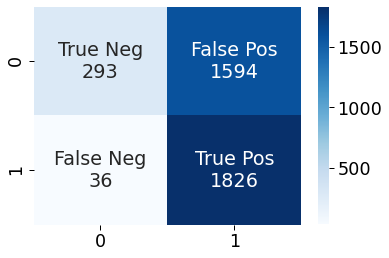

In [195]:
print_CM(y_test, y_pred_3U)

(-3.0, 5.0, 0.0, 1.0)

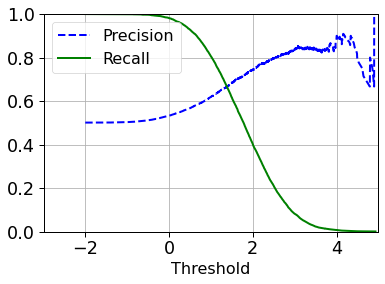

In [196]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="upper left", fontsize=16) 
plt.xlabel("Threshold", fontsize=16)       
plt.grid(True)                              
plt.axis([-3, 5, 0, 1])

Точность - 0.534
Полнота - 0.981
F1 мера - 0.691


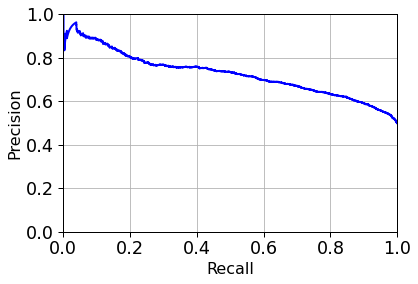

In [197]:
print_all_score(y_test, y_pred_3U, y_pred_probs_3U)

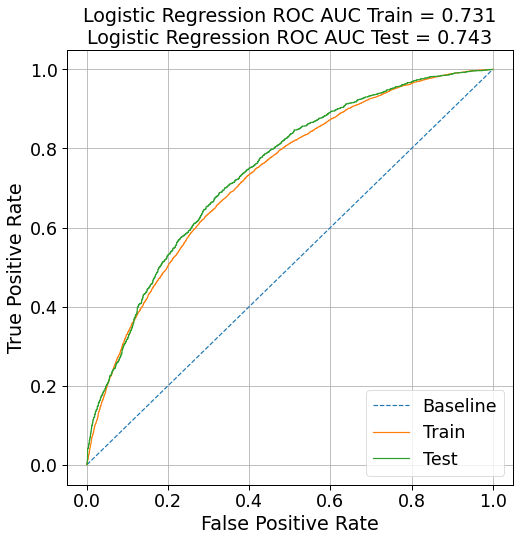

In [198]:
print_ROC_AUC(y_train, y_pred_probs_3U_train, y_test, y_pred_probs_3U)

In [199]:
Mod3 = model_compare('Модель 3', 'Лог.рег', 'U-sampling', y_test, y_pred_3U, y_pred_probs_3U)
Models = pd.concat([Models, Mod3], ignore_index=True,axis=0)
Models

,Модель,Алгоритм,Баланс,Точность,Полнота,F1 мера,ROC AUC
0,Модель 1,Лог.рег,Нет,0.423,0.022,0.043,0.738577
1,Модель 2,Лог.рег,balanced,0.224,0.678,0.337,0.738398
2,Модель 3,Лог.рег,"0:0.2, 1:0.8",0.290,0.427,0.345,0.738501
3,Модель 4_1,Лог.рег (Парам_1),"0:0.2, 1:0.8",0.290,0.427,0.345,0.738498
4,Модель 4_2,Лог.рег (Парам_2),"0:0.2, 1:0.8",0.290,0.427,0.345,0.738498
5,Модель 5,Catboost,"0:0.2, 1:0.8",0.293,0.447,0.354,0.742943
6,Модель 3,Лог.рег,U-sampling,0.534,0.981,0.691,0.742762


Полнота высокая. Более менее точность. Применение этой модели в решении бизнесс задачи будет приемлемым (все-таки около половины платежеспособных клиентов неопознают). 
Но если обратить внимание на диаграмму <B>точность/полнота</B>, то смещая порог оценки можно повысить точность за счет минимального сокращения полноты. 

Полощадь под кривой стала лучше чем у модели 3 на весовом балансе, но хуже чем у модели 5. 

Заметно небольшое переобучение.

In [200]:
# Модель 5
Model_5.fit(X_train, y_train)
#Значения
y_pred_5U = Model_5.predict(X_test)
# Вероятности
y_pred_probs_5U = Model_5.predict_proba(X_test)

# Посчитаем показатели для обучающего набора, что бы следить за переобучением
#Значения
y_pred_5U_train = Model_5.predict(X_train)
# Вероятности
y_pred_probs_5U_train = Model_5.predict_proba(X_train)
 
# Для кривой порога
y_scores_5U = cross_val_predict(Model_5, X_train, y_train, cv=3)
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_5U)

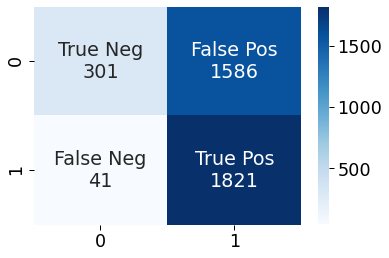

In [201]:
print_CM(y_test, y_pred_5U)

Точность - 0.534
Полнота - 0.978
F1 мера - 0.691


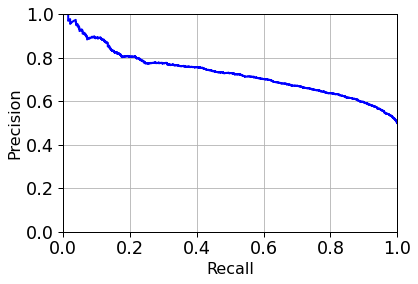

In [202]:
print_all_score(y_test, y_pred_5U, y_pred_probs_5U)

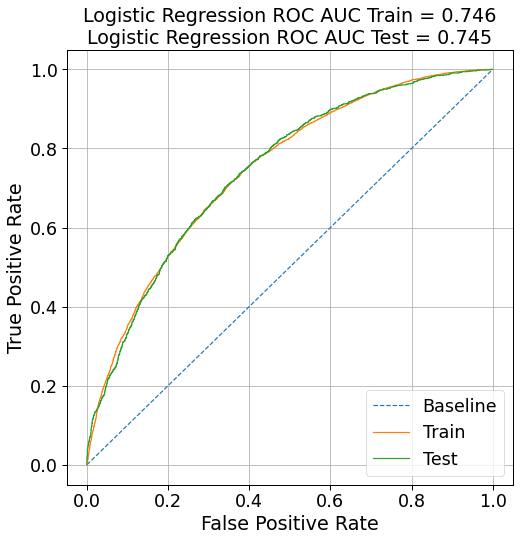

In [203]:
print_ROC_AUC(y_train, y_pred_probs_5U_train, y_test, y_pred_probs_5U)

In [204]:
Mod3 = model_compare('Модель 5', 'Catboost', 'U-sampling', y_test, y_pred_5U, y_pred_probs_5U)
Models = pd.concat([Models, Mod3], ignore_index=True,axis=0)
Models

,Модель,Алгоритм,Баланс,Точность,Полнота,F1 мера,ROC AUC
0,Модель 1,Лог.рег,Нет,0.423,0.022,0.043,0.738577
1,Модель 2,Лог.рег,balanced,0.224,0.678,0.337,0.738398
2,Модель 3,Лог.рег,"0:0.2, 1:0.8",0.290,0.427,0.345,0.738501
3,Модель 4_1,Лог.рег (Парам_1),"0:0.2, 1:0.8",0.290,0.427,0.345,0.738498
4,Модель 4_2,Лог.рег (Парам_2),"0:0.2, 1:0.8",0.290,0.427,0.345,0.738498
5,Модель 5,Catboost,"0:0.2, 1:0.8",0.293,0.447,0.354,0.742943
6,Модель 3,Лог.рег,U-sampling,0.534,0.981,0.691,0.742762
7,Модель 5,Catboost,U-sampling,0.534,0.978,0.691,0.745039


Результат по площади под кривой лучше, чем у Модели 5 на весовом балансе. Да и для решения бизнесс задачи модель с такой обработкой данных сработала лучше.


<a id='6,2'></a>
### 6.2 Применение Oversampling

In [210]:
num_0 = len(test_for_samp[test_for_samp['default']==0])
num_1 = len(test_for_samp[test_for_samp['default']==1])
print(num_0, num_1)

64427 9372


In [211]:
# Увеличим класс 0 до уровня класса 1
oversampled_data = pd.concat([test_for_samp[test_for_samp['default']==0],
                              test_for_samp[test_for_samp['default']==1].sample(num_0, replace=True)])

In [212]:
print(len(oversampled_data))

128854


##### Проверка на модели 3 и модели 5.

In [213]:
# удалим для X целевую переменную и client_id
X_over = oversampled_data.drop(columns = ['default', 'client_id'])
Y_over = oversampled_data['default']

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X_over, Y_over, random_state = RS, test_size=0.2)

In [215]:
# Модель 3
Model_3.fit(X_train, y_train)
#Значения
y_pred_3O = Model_3.predict(X_test)
# Вероятности
y_pred_probs_3O = Model_3.predict_proba(X_test)

# Посчитаем показатели для обучающего набора, что бы следить за переобучением
#Значения
y_pred_3O_train = Model_3.predict(X_train)
# Вероятности
y_pred_probs_3O_train = Model_3.predict_proba(X_train)
 
# Для кривой порога
y_scores_3O = cross_val_predict(Model_3, X_train, y_train, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_3O)

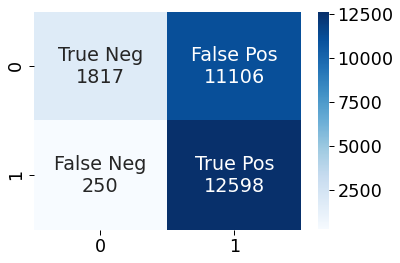

In [216]:
print_CM(y_test, y_pred_3O)

(-3.0, 4.0, 0.0, 1.0)

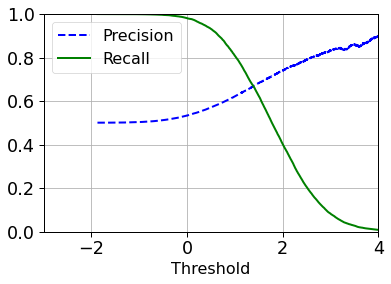

In [217]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="upper left", fontsize=16) 
plt.xlabel("Threshold", fontsize=16)       
plt.grid(True)                              
plt.axis([-3, 4, 0, 1])

Точность - 0.531
Полнота - 0.981
F1 мера - 0.689


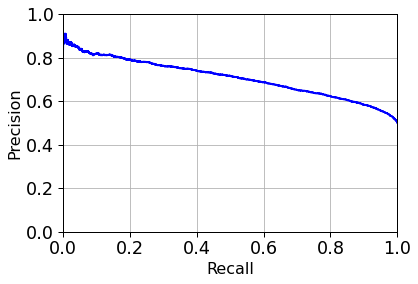

In [218]:
print_all_score(y_test, y_pred_3O, y_pred_probs_3O)

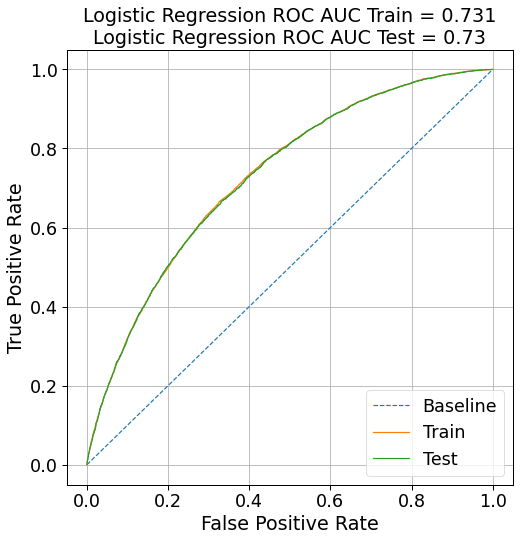

In [219]:
print_ROC_AUC(y_train, y_pred_probs_3O_train, y_test, y_pred_probs_3O)

In [220]:
Mod3 = model_compare('Модель 3', 'Лог.рег', 'O-sampling', y_test, y_pred_3O, y_pred_probs_3O)
Models = pd.concat([Models, Mod3], ignore_index=True,axis=0)
Models

,Модель,Алгоритм,Баланс,Точность,Полнота,F1 мера,ROC AUC
0,Модель 1,Лог.рег,Нет,0.423,0.022,0.043,0.738577
1,Модель 2,Лог.рег,balanced,0.224,0.678,0.337,0.738398
2,Модель 3,Лог.рег,"0:0.2, 1:0.8",0.290,0.427,0.345,0.738501
3,Модель 4_1,Лог.рег (Парам_1),"0:0.2, 1:0.8",0.290,0.427,0.345,0.738498
4,Модель 4_2,Лог.рег (Парам_2),"0:0.2, 1:0.8",0.290,0.427,0.345,0.738498
5,Модель 5,Catboost,"0:0.2, 1:0.8",0.293,0.447,0.354,0.742943
6,Модель 3,Лог.рег,U-sampling,0.534,0.981,0.691,0.742762
7,Модель 5,Catboost,U-sampling,0.534,0.978,0.691,0.745039
8,Модель 3,Лог.рег,O-sampling,0.531,0.981,0.689,0.729696


Разница между овер и андерсемплингом в модели 3 - ROC AUC стала ниже

In [221]:
# Модель 5
Model_5.fit(X_train, y_train)
#Значения
y_pred_5O = Model_5.predict(X_test)
# Вероятности
y_pred_probs_5O = Model_5.predict_proba(X_test)

# Посчитаем показатели для обучающего набора, что бы следить за переобучением
#Значения
y_pred_5O_train = Model_5.predict(X_train)
# Вероятности
y_pred_probs_5O_train = Model_5.predict_proba(X_train)
 
# Для кривой порога
y_scores_5O = cross_val_predict(Model_5, X_train, y_train, cv=3)
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_5O)

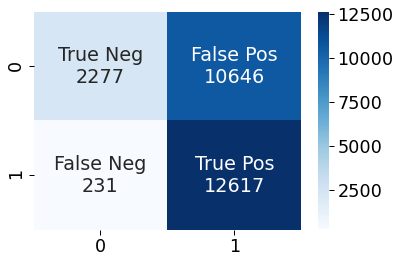

In [222]:
print_CM(y_test, y_pred_5O)

Точность - 0.542
Полнота - 0.982
F1 мера - 0.699


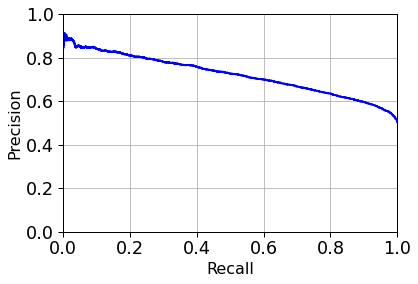

In [223]:
print_all_score(y_test, y_pred_5O, y_pred_probs_5O)

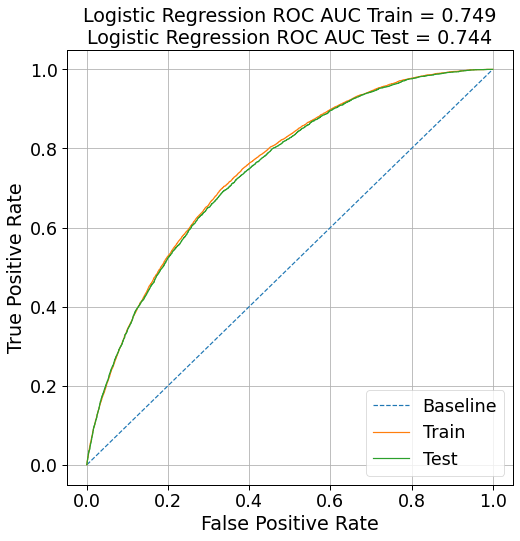

In [224]:
print_ROC_AUC(y_train, y_pred_probs_5O_train, y_test, y_pred_probs_5O)

In [225]:
Mod3 = model_compare('Модель 5', 'Catboost', 'O-sampling', y_test, y_pred_5O, y_pred_probs_5O)
Models = pd.concat([Models, Mod3], ignore_index=True,axis=0)
Models

,Модель,Алгоритм,Баланс,Точность,Полнота,F1 мера,ROC AUC
0,Модель 1,Лог.рег,Нет,0.423,0.022,0.043,0.738577
1,Модель 2,Лог.рег,balanced,0.224,0.678,0.337,0.738398
2,Модель 3,Лог.рег,"0:0.2, 1:0.8",0.290,0.427,0.345,0.738501
3,Модель 4_1,Лог.рег (Парам_1),"0:0.2, 1:0.8",0.290,0.427,0.345,0.738498
4,Модель 4_2,Лог.рег (Парам_2),"0:0.2, 1:0.8",0.290,0.427,0.345,0.738498
5,Модель 5,Catboost,"0:0.2, 1:0.8",0.293,0.447,0.354,0.742943
6,Модель 3,Лог.рег,U-sampling,0.534,0.981,0.691,0.742762
7,Модель 5,Catboost,U-sampling,0.534,0.978,0.691,0.745039
8,Модель 3,Лог.рег,O-sampling,0.531,0.981,0.689,0.729696
9,Модель 5,Catboost,O-sampling,0.542,0.982,0.699,0.744401


Аналогично, хотя, навреное и неудивительно, данные то одни и теже.

<a id='6.3'></a>
### 6.3 Undersampling и Oversampling с использованием imbalanced-learn

##### 6.3.1 Tomek Links

In [230]:
X_TL = test_for_samp.drop(columns = ['default', 'client_id'])
Y_TL = test_for_samp['default']

In [233]:
tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_resample(X_TL, Y_TL)

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, random_state = RS, test_size=0.2)

In [235]:
# Модель 3
Model_3.fit(X_train, y_train)
#Значения
y_pred_3tl = Model_3.predict(X_test)
# Вероятности
y_pred_probs_3tl = Model_3.predict_proba(X_test)

# Посчитаем показатели для обучающего набора, что бы следить за переобучением
#Значения
y_pred_3tl_train = Model_3.predict(X_train)
# Вероятности
y_pred_probs_3tl_train = Model_3.predict_proba(X_train)
 
# Для кривой порога
y_scores_3tl = cross_val_predict(Model_3, X_train, y_train, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_3tl)

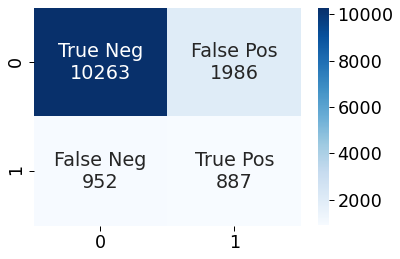

In [236]:
print_CM(y_test, y_pred_3tl)

(-3.0, 4.0, 0.0, 1.0)

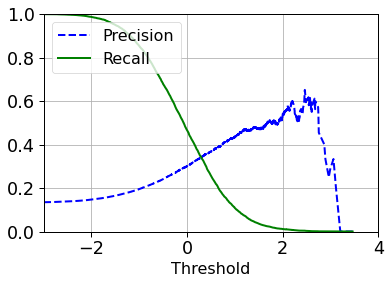

In [237]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="upper left", fontsize=16) 
plt.xlabel("Threshold", fontsize=16)       
plt.grid(True)                              
plt.axis([-3, 4, 0, 1])

Точность - 0.309
Полнота - 0.482
F1 мера - 0.376


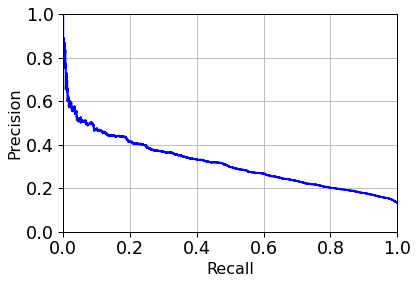

In [238]:
print_all_score(y_test, y_pred_3tl, y_pred_probs_3tl)

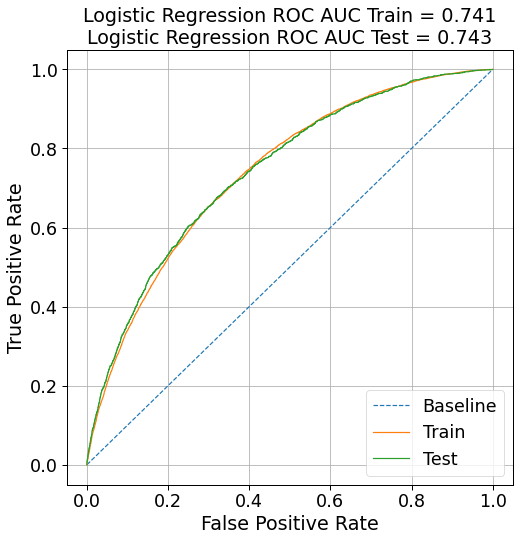

In [239]:
print_ROC_AUC(y_train, y_pred_probs_3tl_train, y_test, y_pred_probs_3tl)

In [240]:
Mod3 = model_compare('Модель 3', 'Лог.рег', 'TomekLinks', y_test, y_pred_3tl, y_pred_probs_3tl)
Models = pd.concat([Models, Mod3], ignore_index=True,axis=0)
Models

,Модель,Алгоритм,Баланс,Точность,Полнота,F1 мера,ROC AUC
0,Модель 1,Лог.рег,Нет,0.423,0.022,0.043,0.738577
1,Модель 2,Лог.рег,balanced,0.224,0.678,0.337,0.738398
2,Модель 3,Лог.рег,"0:0.2, 1:0.8",0.290,0.427,0.345,0.738501
3,Модель 4_1,Лог.рег (Парам_1),"0:0.2, 1:0.8",0.290,0.427,0.345,0.738498
4,Модель 4_2,Лог.рег (Парам_2),"0:0.2, 1:0.8",0.290,0.427,0.345,0.738498
5,Модель 5,Catboost,"0:0.2, 1:0.8",0.293,0.447,0.354,0.742943
6,Модель 3,Лог.рег,U-sampling,0.534,0.981,0.691,0.742762
7,Модель 5,Catboost,U-sampling,0.534,0.978,0.691,0.745039
8,Модель 3,Лог.рег,O-sampling,0.531,0.981,0.689,0.729696
9,Модель 5,Catboost,O-sampling,0.542,0.982,0.699,0.744401


ROC AUC - лучшая среди всех моделей 3, но точность и полнота не очень.

In [241]:
# Модель 5
Model_5.fit(X_train, y_train)
#Значения
y_pred_5tl = Model_5.predict(X_test)
# Вероятности
y_pred_probs_5tl = Model_5.predict_proba(X_test)

# Посчитаем показатели для обучающего набора, что бы следить за переобучением
#Значения
y_pred_5tl_train = Model_5.predict(X_train)
# Вероятности
y_pred_probs_5tl_train = Model_5.predict_proba(X_train)
 
# Для кривой порога
y_scores_5tl = cross_val_predict(Model_5, X_train, y_train, cv=3)
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_5tl)

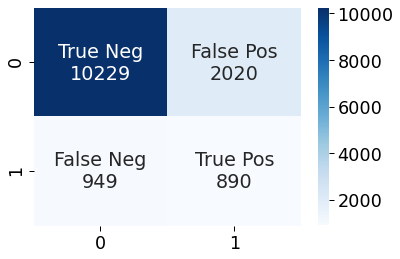

In [242]:
print_CM(y_test, y_pred_5tl)

Точность - 0.306
Полнота - 0.484
F1 мера - 0.375


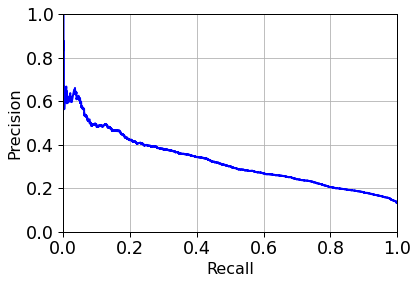

In [243]:
print_all_score(y_test, y_pred_5tl, y_pred_probs_5tl)

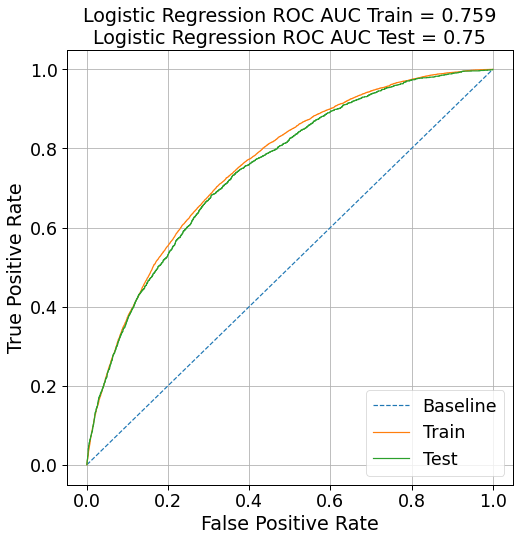

In [244]:
print_ROC_AUC(y_train, y_pred_probs_5tl_train, y_test, y_pred_probs_5tl)

In [245]:
Mod3 = model_compare('Модель 5', 'Catboost', 'TomekLinks', y_test, y_pred_5tl, y_pred_probs_5tl)
Models = pd.concat([Models, Mod3], ignore_index=True,axis=0)
Models

,Модель,Алгоритм,Баланс,Точность,Полнота,F1 мера,ROC AUC
0,Модель 1,Лог.рег,Нет,0.423,0.022,0.043,0.738577
1,Модель 2,Лог.рег,balanced,0.224,0.678,0.337,0.738398
2,Модель 3,Лог.рег,"0:0.2, 1:0.8",0.290,0.427,0.345,0.738501
3,Модель 4_1,Лог.рег (Парам_1),"0:0.2, 1:0.8",0.290,0.427,0.345,0.738498
4,Модель 4_2,Лог.рег (Парам_2),"0:0.2, 1:0.8",0.290,0.427,0.345,0.738498
5,Модель 5,Catboost,"0:0.2, 1:0.8",0.293,0.447,0.354,0.742943
6,Модель 3,Лог.рег,U-sampling,0.534,0.981,0.691,0.742762
7,Модель 5,Catboost,U-sampling,0.534,0.978,0.691,0.745039
8,Модель 3,Лог.рег,O-sampling,0.531,0.981,0.689,0.729696
9,Модель 5,Catboost,O-sampling,0.542,0.982,0.699,0.744401


Еее!!! апнули кагловский скор на 0.00018...

##### 6.3.2 Оверсэмплинг со SMOTE

In [259]:
X_SM = test_for_samp.drop(columns = ['default', 'client_id'])
Y_SM = test_for_samp['default']

In [260]:
sm = SMOTE(sampling_strategy='minority')
X_sm, y_sm = sm.fit_resample(X_SM, Y_SM)

In [261]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, random_state = RS, test_size=0.2)

In [262]:
# Модель 3
Model_3.fit(X_train, y_train)
#Значения
y_pred_3sm = Model_3.predict(X_test)
# Вероятности
y_pred_probs_3sm = Model_3.predict_proba(X_test)

# Посчитаем показатели для обучающего набора, что бы следить за переобучением
#Значения
y_pred_3sm_train = Model_3.predict(X_train)
# Вероятности
y_pred_probs_3sm_train = Model_3.predict_proba(X_train)
 
# Для кривой порога
y_scores_3sm = cross_val_predict(Model_3, X_train, y_train, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_3sm)

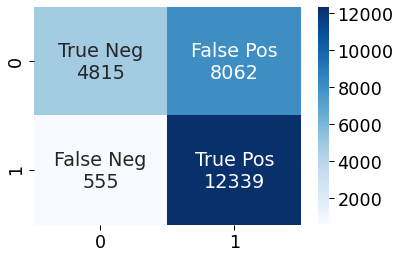

In [263]:
print_CM(y_test, y_pred_3sm)

(-3.0, 4.0, 0.3, 1.0)

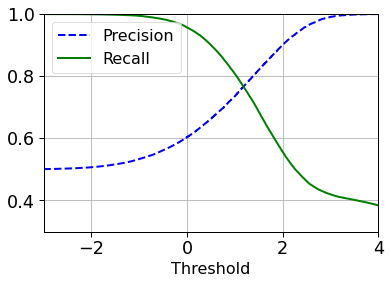

In [264]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="upper left", fontsize=16) 
plt.xlabel("Threshold", fontsize=16)       
plt.grid(True)                              
plt.axis([-3, 4, 0.3, 1])

Точность - 0.605
Полнота - 0.957
F1 мера - 0.741


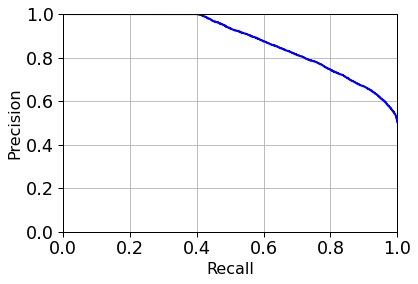

In [265]:
print_all_score(y_test, y_pred_3sm, y_pred_probs_3sm)

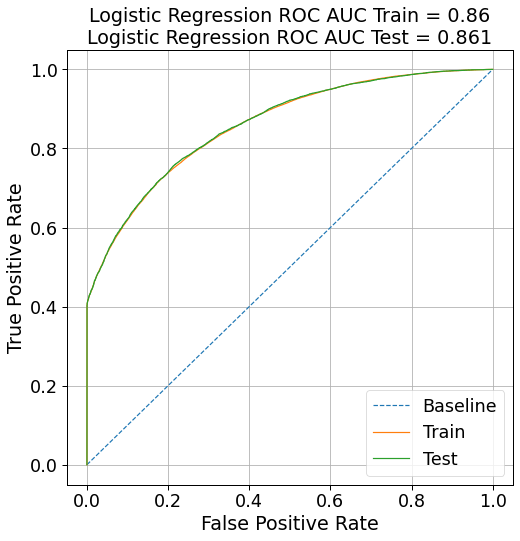

In [266]:
print_ROC_AUC(y_train, y_pred_probs_3sm_train, y_test, y_pred_probs_3sm)

In [267]:
Mod3 = model_compare('Модель 3', 'Лог.рег', 'SMOTE', y_test, y_pred_3sm, y_pred_probs_3sm)
Models = pd.concat([Models, Mod3], ignore_index=True,axis=0)
Models

,Модель,Алгоритм,Баланс,Точность,Полнота,F1 мера,ROC AUC
0,Модель 1,Лог.рег,Нет,0.423,0.022,0.043,0.738577
1,Модель 2,Лог.рег,balanced,0.224,0.678,0.337,0.738398
2,Модель 3,Лог.рег,"0:0.2, 1:0.8",0.290,0.427,0.345,0.738501
3,Модель 4_1,Лог.рег (Парам_1),"0:0.2, 1:0.8",0.290,0.427,0.345,0.738498
4,Модель 4_2,Лог.рег (Парам_2),"0:0.2, 1:0.8",0.290,0.427,0.345,0.738498
5,Модель 5,Catboost,"0:0.2, 1:0.8",0.293,0.447,0.354,0.742943
6,Модель 3,Лог.рег,U-sampling,0.534,0.981,0.691,0.742762
7,Модель 5,Catboost,U-sampling,0.534,0.978,0.691,0.745039
8,Модель 3,Лог.рег,O-sampling,0.531,0.981,0.689,0.729696
9,Модель 5,Catboost,O-sampling,0.542,0.982,0.699,0.744401


огоськи... нет, там встатьях говорили, что верная стратегия борьбы с дисбалансом может сильно изменить проект...

In [268]:
# Модель 5
Model_51 = CatBoostClassifier(n_estimators=1000, depth=2, class_weights=balance, logging_level='Silent')
Model_51.fit(X_train, y_train)
#Значения
y_pred_5sm = Model_51.predict(X_test)
# Вероятности
y_pred_probs_5sm = Model_51.predict_proba(X_test)

# Посчитаем показатели для обучающего набора, что бы следить за переобучением
#Значения
y_pred_5sm_train = Model_51.predict(X_train)
# Вероятности
y_pred_probs_5sm_train = Model_51.predict_proba(X_train)
 
# Для кривой порога
y_scores_5sm = cross_val_predict(Model_51, X_train, y_train, cv=3)
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_5sm)

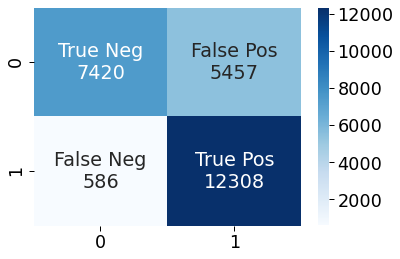

In [269]:
print_CM(y_test, y_pred_5sm)

Точность - 0.693
Полнота - 0.955
F1 мера - 0.803


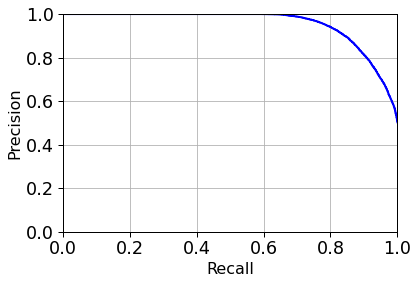

In [270]:
print_all_score(y_test, y_pred_5sm, y_pred_probs_5sm)

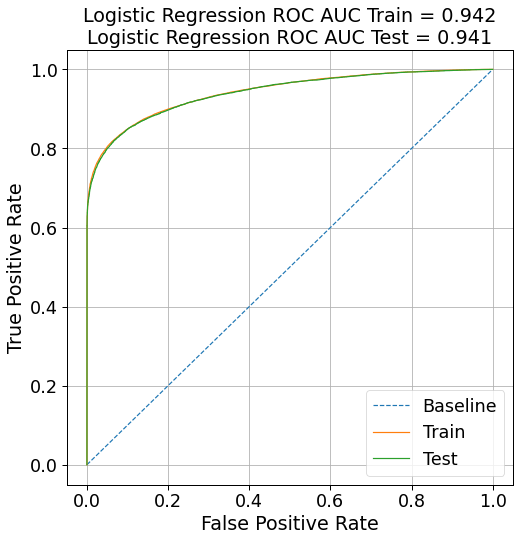

In [271]:
print_ROC_AUC(y_train, y_pred_probs_5sm_train, y_test, y_pred_probs_5sm)

In [272]:
Mod3 = model_compare('Модель 5', 'Catboost', 'SMOTE', y_test, y_pred_5sm, y_pred_probs_5sm)
Models = pd.concat([Models, Mod3], ignore_index=True,axis=0)
Models

,Модель,Алгоритм,Баланс,Точность,Полнота,F1 мера,ROC AUC
0,Модель 1,Лог.рег,Нет,0.423,0.022,0.043,0.738577
1,Модель 2,Лог.рег,balanced,0.224,0.678,0.337,0.738398
2,Модель 3,Лог.рег,"0:0.2, 1:0.8",0.290,0.427,0.345,0.738501
3,Модель 4_1,Лог.рег (Парам_1),"0:0.2, 1:0.8",0.290,0.427,0.345,0.738498
4,Модель 4_2,Лог.рег (Парам_2),"0:0.2, 1:0.8",0.290,0.427,0.345,0.738498
5,Модель 5,Catboost,"0:0.2, 1:0.8",0.293,0.447,0.354,0.742943
6,Модель 3,Лог.рег,U-sampling,0.534,0.981,0.691,0.742762
7,Модель 5,Catboost,U-sampling,0.534,0.978,0.691,0.745039
8,Модель 3,Лог.рег,O-sampling,0.531,0.981,0.689,0.729696
9,Модель 5,Catboost,O-sampling,0.542,0.982,0.699,0.744401


Ну... здесь явно, где-то какая-то ошибка...